In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
random.seed(10)

In [3]:
class Neuron:
    def __init__(self, id, connected_neurons=None):
        self.__id = id
        self.__output = float(0)
        self.__delta = float(0)
        self.__weight = random.uniform(-0.8, 0.8)

        if connected_neurons is None:
            connected_neurons = []
        self.__connections = {}
        for n in connected_neurons:
            self.__connections[n] = random.uniform(-1.0, 1.0)

    @property
    def output(self):
        return self.__output

    @output.setter
    def output(self, output):
        self.__output = output

    @property
    def delta(self):
        return self.__delta

    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    @property
    def connections(self):
        return self.__connections

    @connections.setter
    def connections(self, connections):
        self.__connections = connections

    @property
    def weight(self):
        return self.__weight

    @weight.setter
    def weight(self, weight):
        self.__weight = weight

    def __hash__(self):
        return hash(self.__id)

In [4]:
import math
import random

class Sigmoid:
    
    def apply(self, x: float):
        return 1 / (1 + math.exp((-x)))
    
    def approximation_c(self, x: float, h = 0.01):
        E_w_r = self.apply(x + h)
        E_w_l = self.apply(x - h)
        
        result = (E_w_r - E_w_l) / (2*h)
        
        return result

In [5]:
class Layer:
    def __init__(self, neurons: [Neuron]):
        self.__neurons = neurons

    @property
    def neurons(self):
        return self.__neurons

    @neurons.setter
    def neurons(self, neurons):
        self.__neurons = neurons


class ActiveLayer(Layer):
    def __init__(self, neurons: [Neuron]):
        super(ActiveLayer, self).__init__(neurons)
        self.__activation_func = Sigmoid()

    def apply_func(self, x):
        return self.__activation_func.apply(x)
    
    def apply_approx_der_c(self, neuron):
        return self.__activation_func.approximation_c(neuron.output)

In [6]:
class Perceptron:
    def __init__(self,
                 layers_params=None,
                 rate=0.1,
                 batch_size=50,
                 epoch_count=10,
                 delta_razn=0.01):
        if layers_params is None:
            layers_params = [1, 1]

        self.__rate = rate
        self.__batch_size = batch_size
        self.__epoch_count = epoch_count
        self.__delta_razn = delta_razn
        self.__layers_params = layers_params

        self.__train_avg_error = 0
        self.__res = []
        self.__create_layers(layers_params)


    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def __create_layers(self, layers_params):
        n_seq = 0
        input_neuron = Neuron(n_seq)
        layers = [Layer([input_neuron])]
        n_seq += 1

        prev_neurons = [input_neuron]
        neurons = []

        for p in layers_params:
            for j in range(p):
                neurons.append(Neuron(n_seq, prev_neurons))
                n_seq += 1
            layers.append(ActiveLayer(neurons))
            prev_neurons = neurons
            neurons = []

        layers.append(ActiveLayer([Neuron(n_seq, prev_neurons)]))

        self.__layers = layers

    def fit(self, input_values: [[float]], output_values: [[float]]):
        for i in range(self.__epoch_count):
            indices = random.sample(range(len(input_values)), self.__batch_size)

            error = 0
            for iv, ov in zip([input_values[i] for i in indices], [output_values[i] for i in indices]):
                e = self.__train_example(iv, ov)
                error += e
            self.__train_avg_error += error / self.__batch_size

        self.__train_avg_error /= self.__epoch_count

    def predict(self, input_values: [[float]]):
        self.__res = []
        for iv in input_values:
            self.__set_input_layer_values(iv)
            self.__forward_propagate()
            self.__res.append([n.output for n in self.__layers[len(self.__layers) - 1].neurons])
        return self.__res

    def __train_example(self, input_value: [float], output_value: [float]):
        self.__set_input_layer_values(input_value)
        self.__forward_propagate()
        self.__backward_propagate(output_value)
        return self.__calc_error(output_value)

    def __set_input_layer_values(self, input_value):
        __input_layer = self.__layers[0]
        for i in range(len(__input_layer.neurons)):
            __input_layer.neurons[i].output = input_value[i]

    def __forward_propagate(self):
        for i in range(1, len(self.__layers)):
            for n in self.__layers[i].neurons:
                output = n.weight

                for connected_neuron, v in n.connections.items():
                    output += connected_neuron.output * v

                if i == len(self.__layers) - 1:
                    n.output = output
                else:
                    n.output = self.__layers[i].apply_func(output)

        return

    def __backward_propagate(self, output_value: [float]):
        for i in reversed(range(1, len(self.__layers))):
            cur_layer = self.__layers[i]

            if i == len(self.__layers) - 1:
                for n, o in zip(cur_layer.neurons, output_value):
                    n.delta = (n.output - o)
            else:
                for n in cur_layer.neurons:
                    correction = 0
                    for pn in self.__layers[i + 1].neurons:
                        correction += pn.delta * pn.connections[n]
                    n.delta = cur_layer.apply_approx_der_c(n) * correction

        for i in range(1, len(self.__layers)):
            cur_layer = self.__layers[i]
            for n in cur_layer.neurons:
                n.weight -= self.__rate * n.delta
                for connected_neuron, v in n.connections.items():
                    n.connections[connected_neuron] -= self.__rate * connected_neuron.output * n.delta

        return
                

    def __calc_error(self, output_value: [float]):
        res = 0
        for n, o in zip(self.__layers[len(self.__layers) - 1].neurons, output_value):
            res += (o - n.output) ** 2
        return res / 2

In [7]:
def get_func_value(func, x):
    if func == 'cos':
        return np.cos(2 * np.pi * x)
    if func == 'poly':
        return 5 * x ** 3 + x ** 2 + 5
    if func == 'sin':
        return x * np.sin(2 * np.pi * x)
    if func == 'x':
        return x

In [8]:
def get_normal_noised_func_value(f, x, mean=0, sd=1):
    f = get_func_value(f, x)
    noise = np.random.normal(mean, sd, f.shape)
    return f, f + noise

In [9]:
def get_layers_params():
    p_1 = []
    for i in range(1, 4):
        p_1.append([i])

    p_2 = []
    for p in p_1:
        for i in range(1, 4):
            p_2.append([p[0], i])

    p__ = p_1 + p_2
    return p__

In [10]:
count = 100
x = np.linspace(0, 1, num=count)
x_parts = np.array_split(x, 5)

In [11]:
params = get_layers_params()
print("Testing set of hidden layers params:\n" + str(params))

Testing set of hidden layers params:
[[1], [2], [3], [1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]


Полином

In [12]:
# from sklearn.metrics import mean_squared_error
# 
# results = []
# 
# for param in params:
#     
#     model = Perceptron(
#         rate=0.1,
#         layers_params=param,
#         epoch_count=200,
#         batch_size=20
#     )
#     
#     y, y_noised = get_normal_noised_func_value('poly', x, 0, 0.1)
#     model.fit([[v] for v in x], [[v] for v in y_noised])
#     res = model.predict([[v] for v in x])
#     y_pred = [[v][0] for v in res]
#     
#     plt.title('params = ' + str(param) + '\n' + 'MSE = ' + str(mean_squared_error(y_noised, y_pred)))
#     plt.plot(x, y_pred, 'g-')
#     plt.plot(x, y_noised, 'r.')
#     plt.plot(x, y, 'b-')
#     plt.show()
#     
#     results.append((param, mean_squared_error(y_noised, y_pred)))

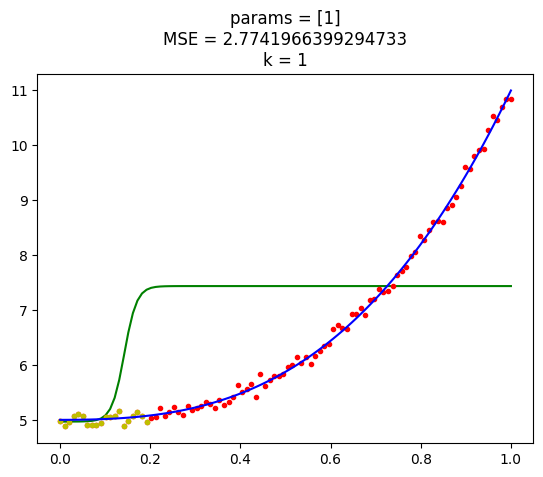

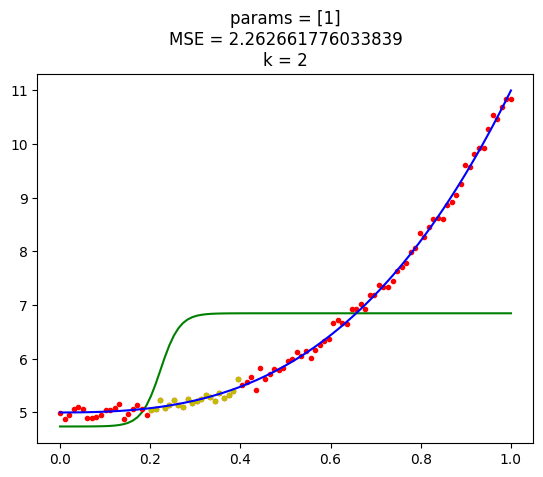

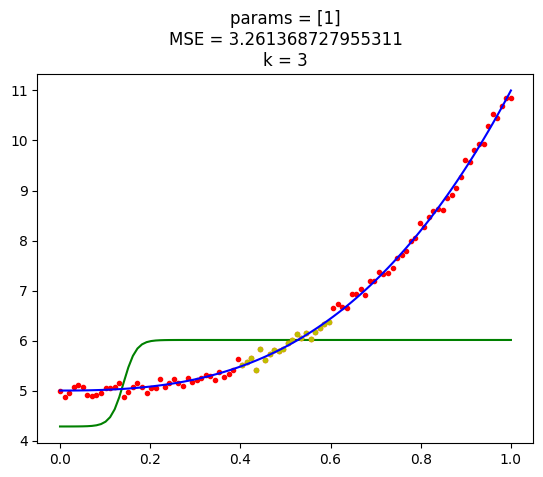

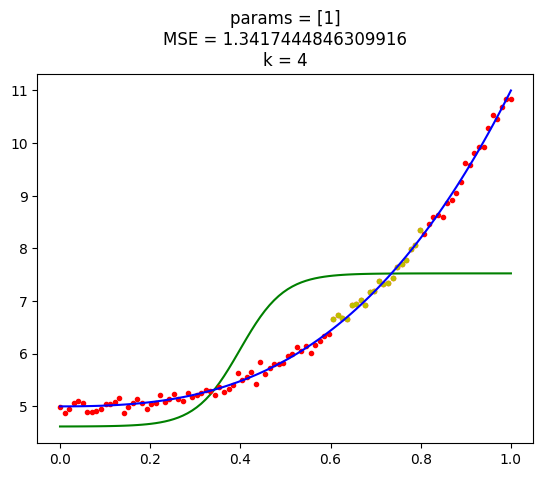

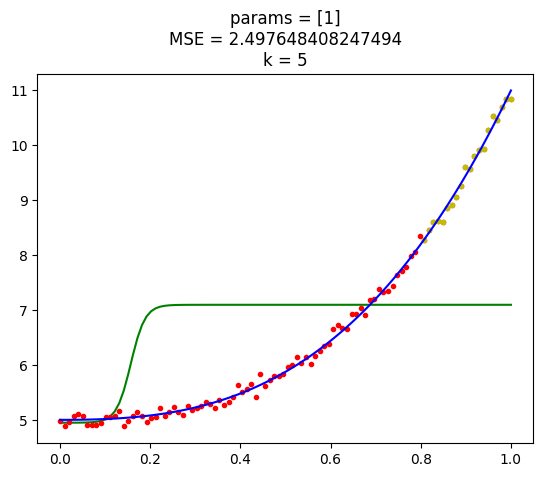

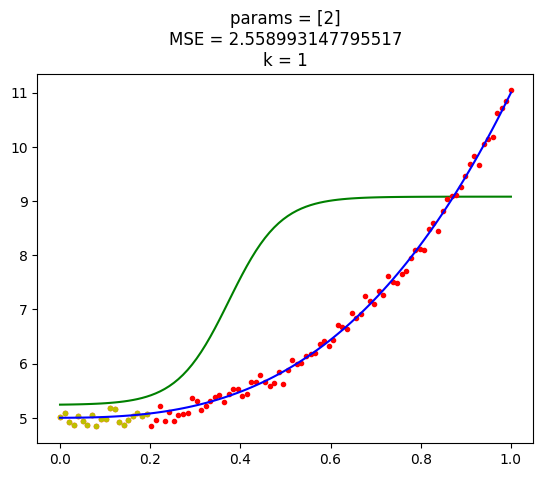

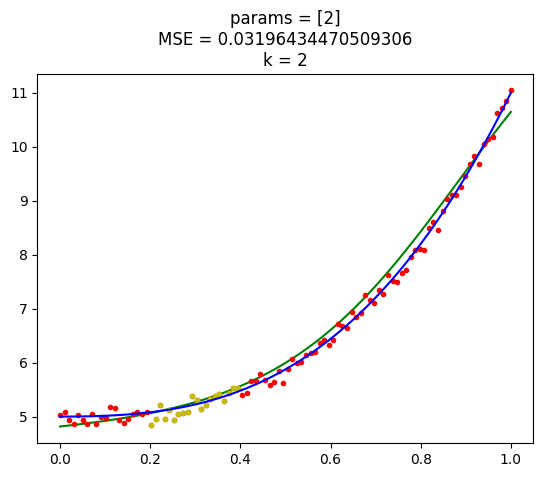

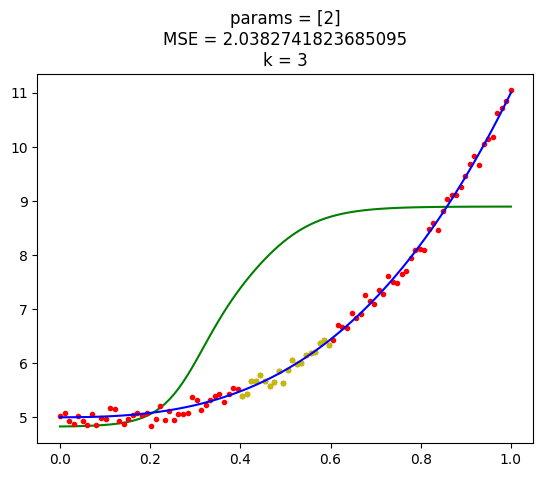

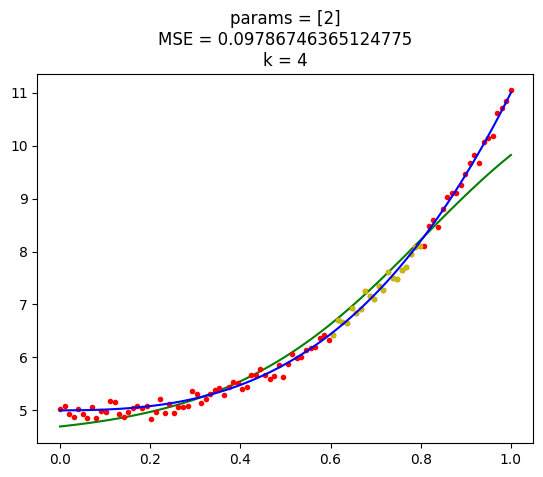

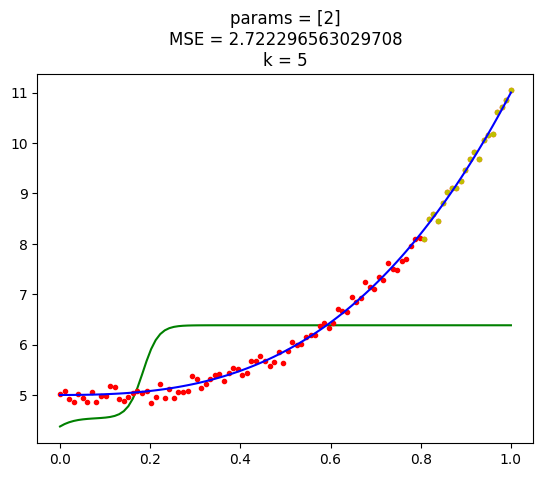

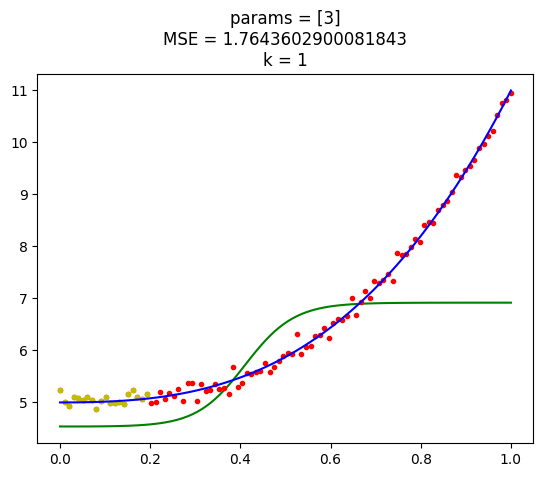

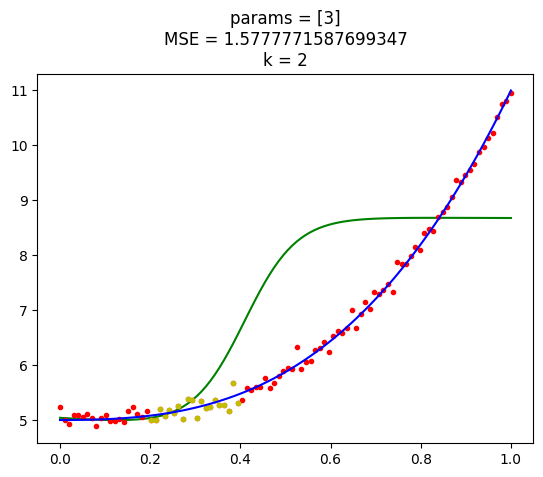

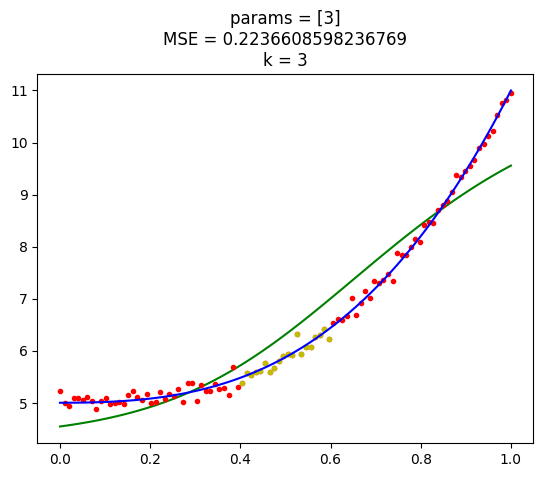

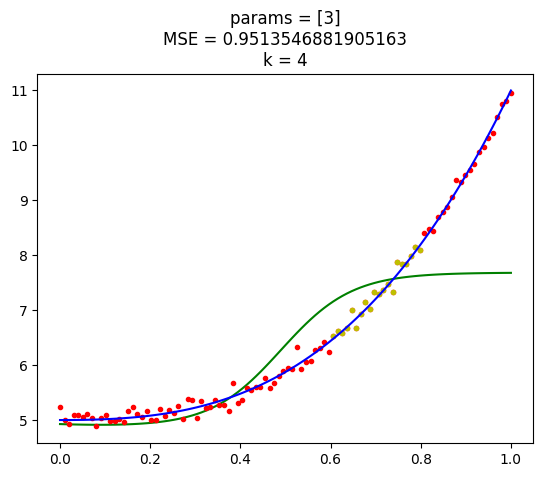

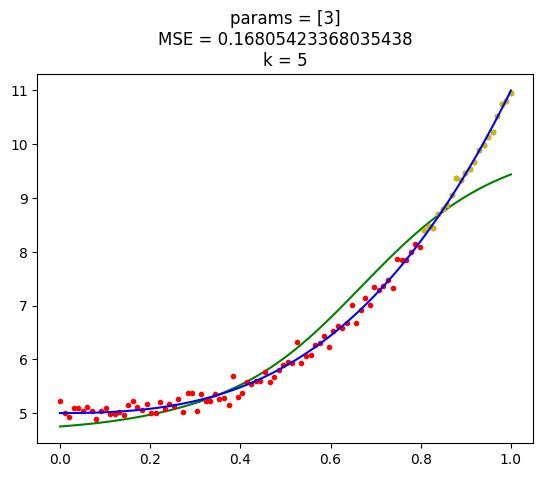

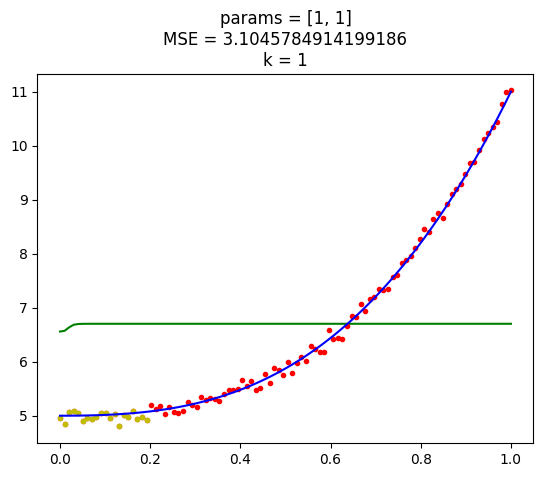

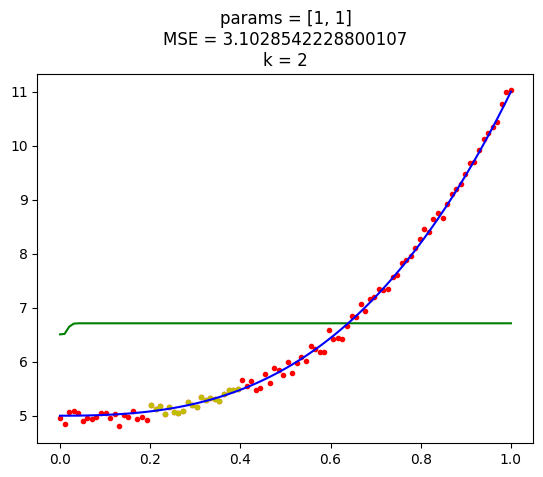

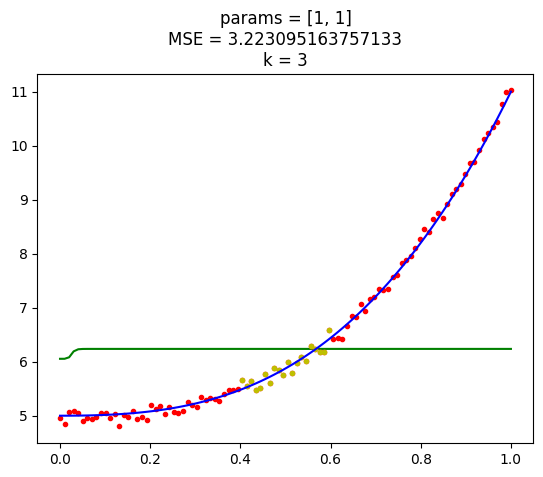

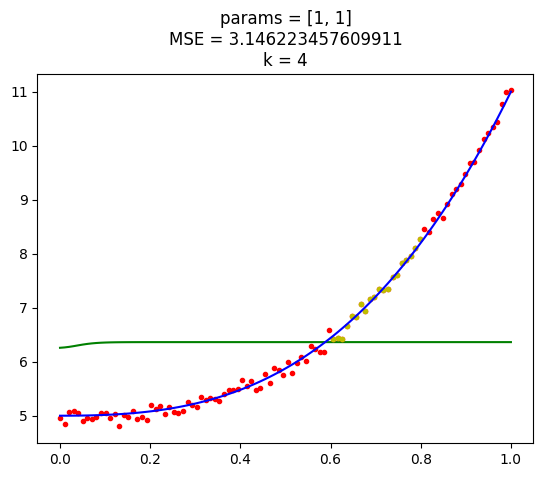

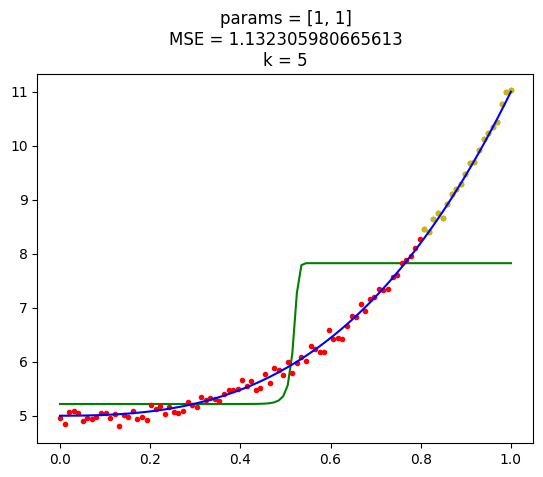

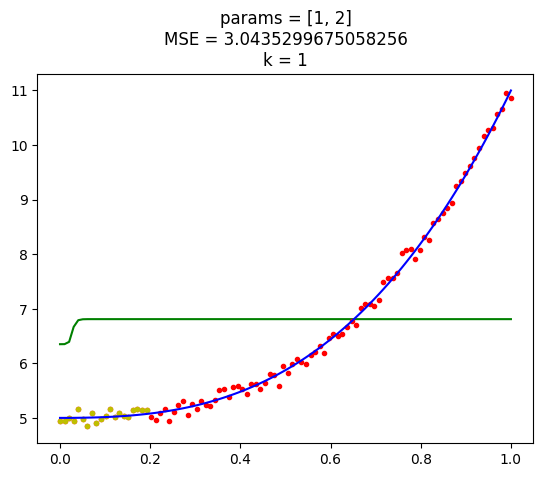

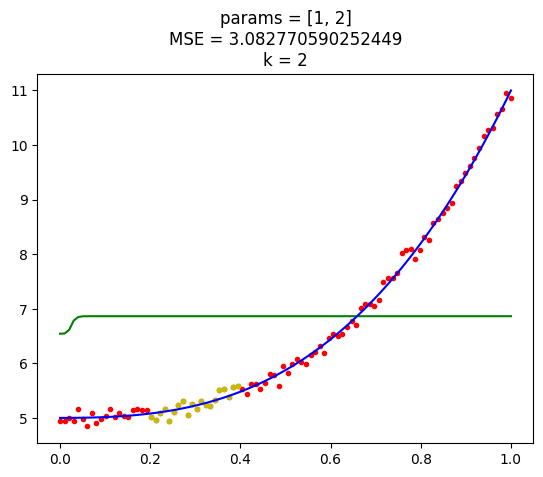

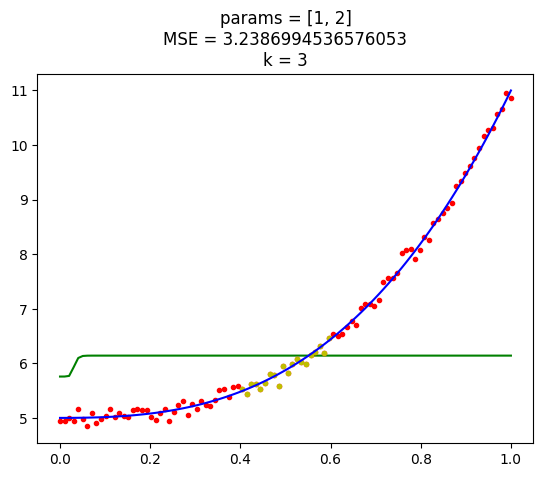

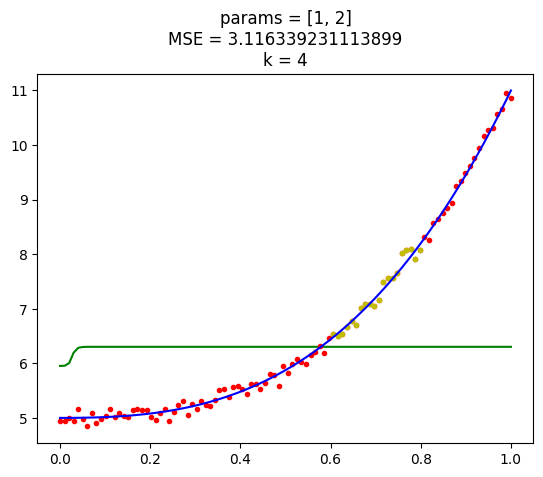

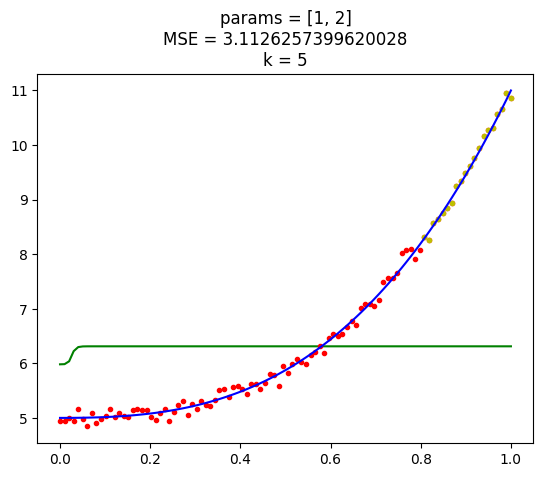

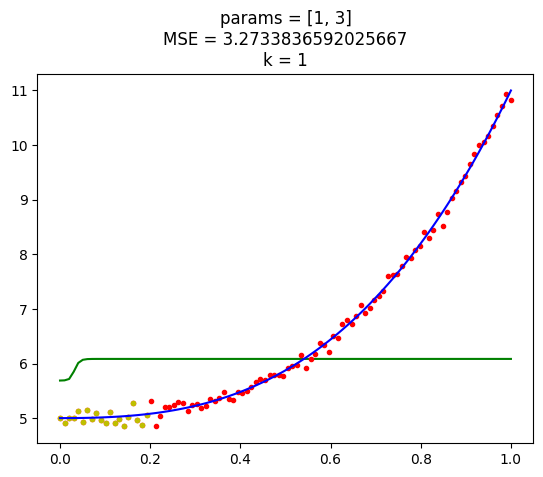

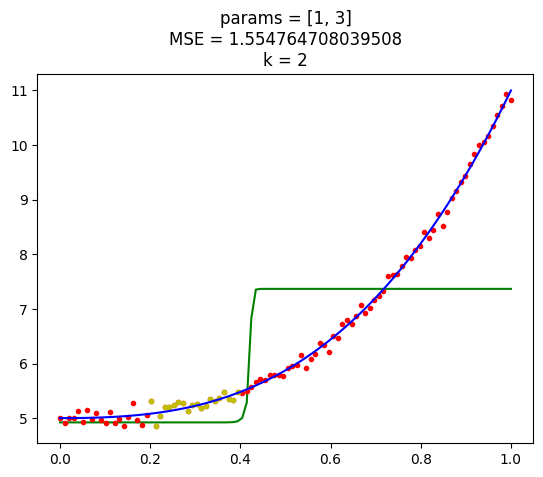

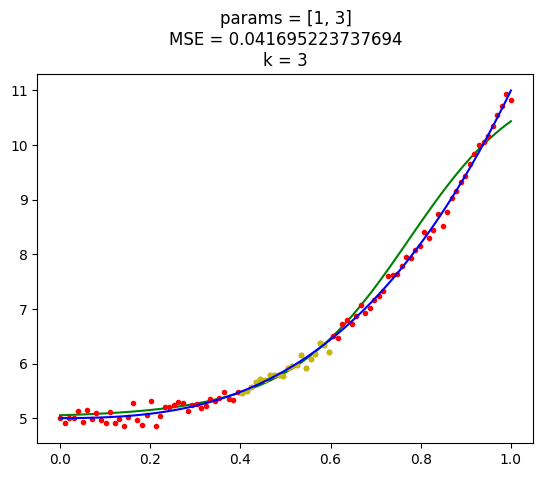

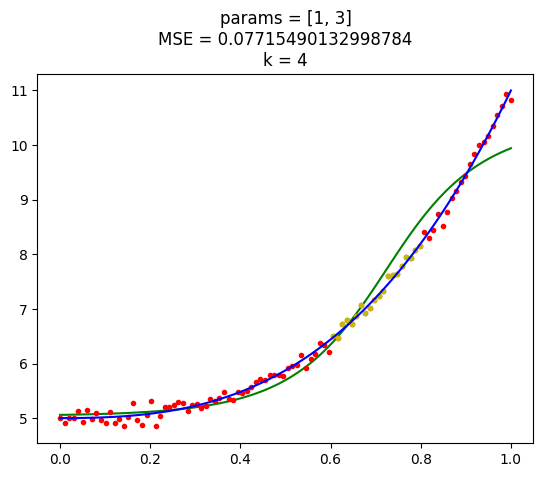

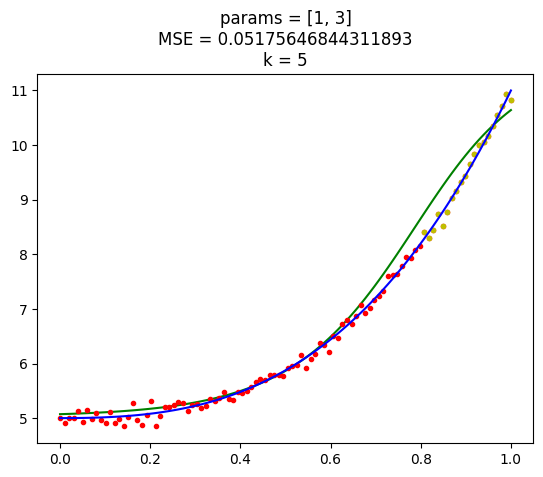

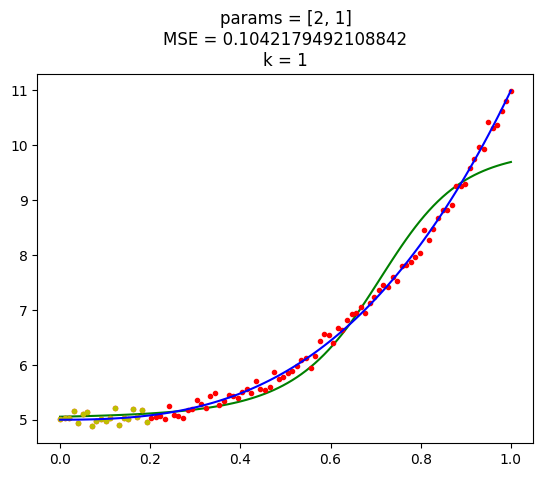

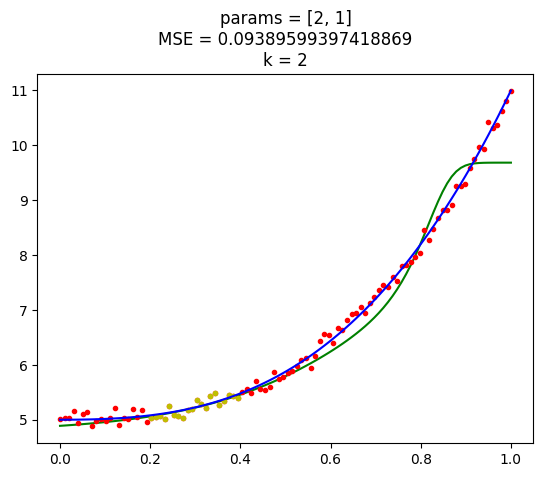

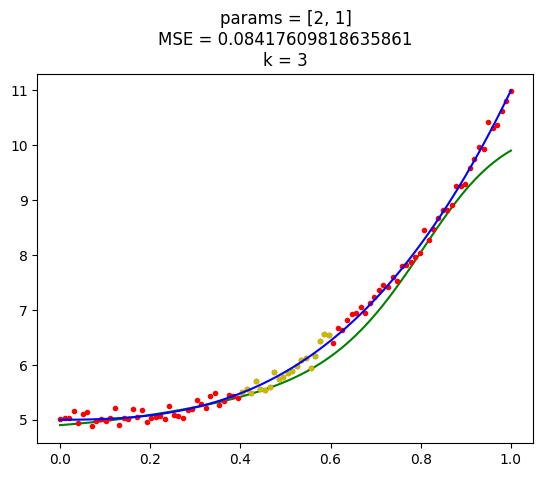

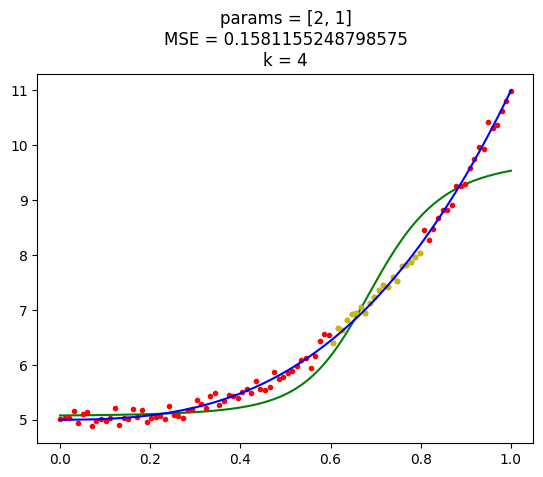

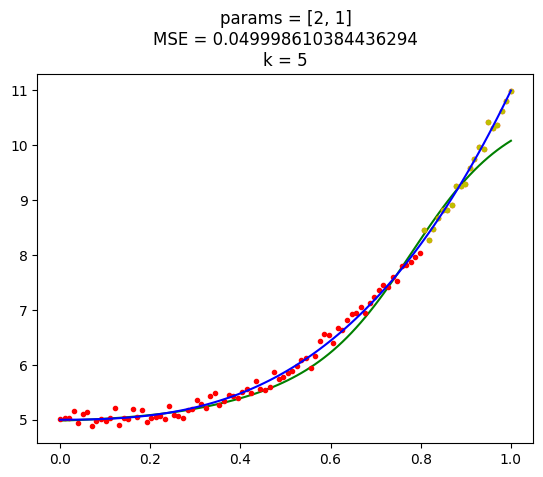

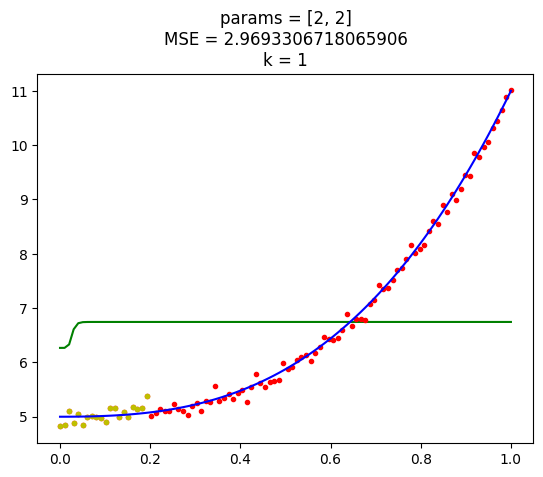

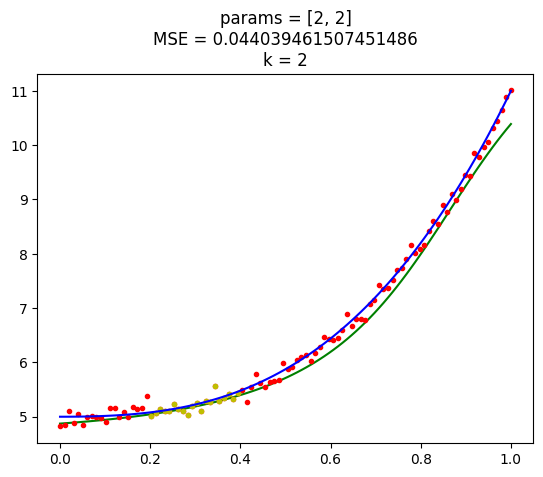

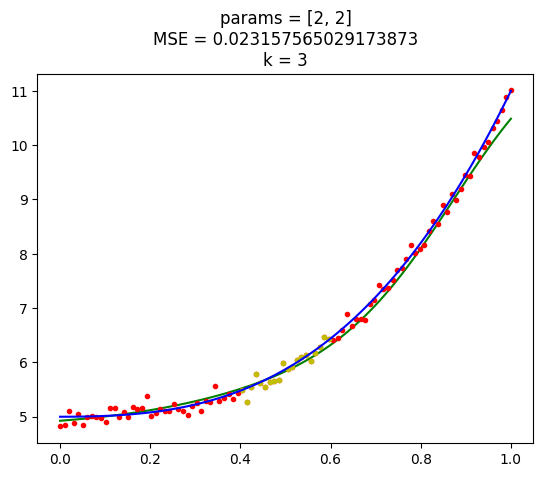

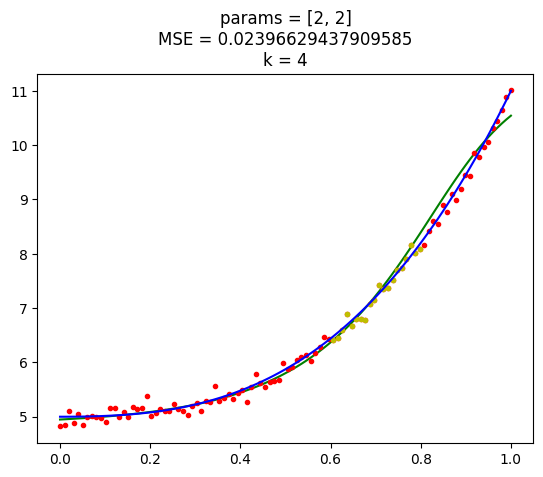

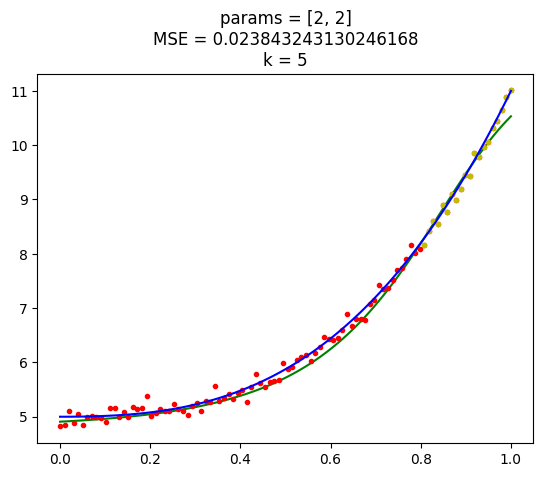

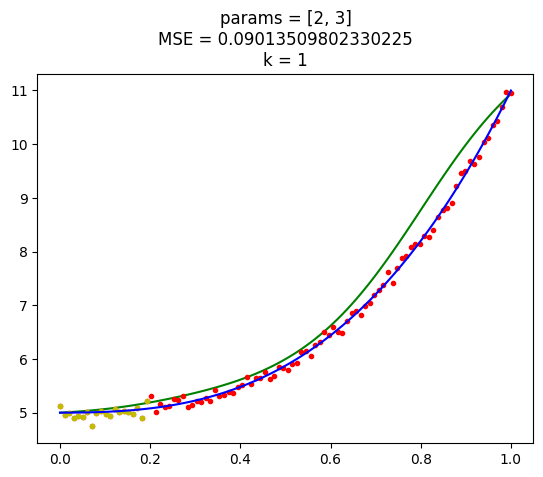

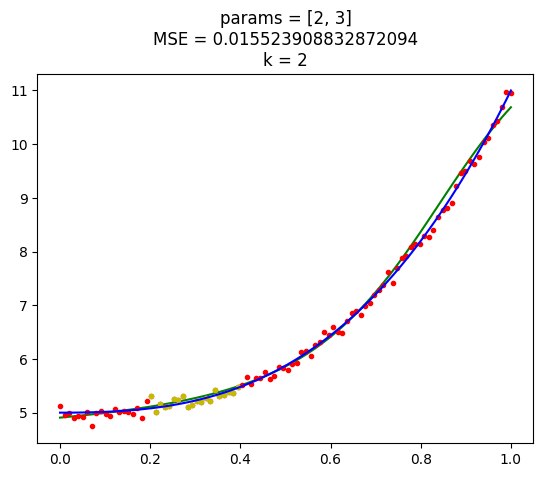

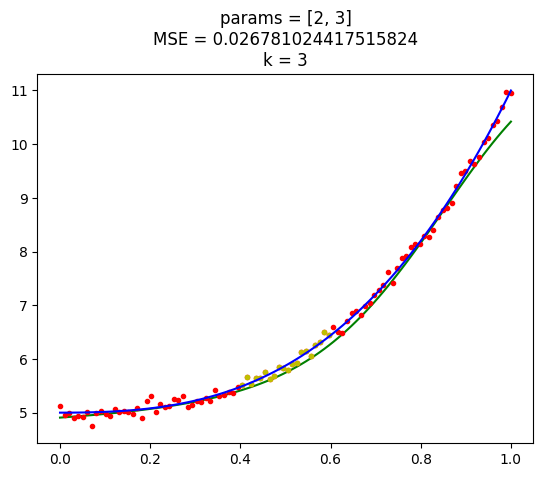

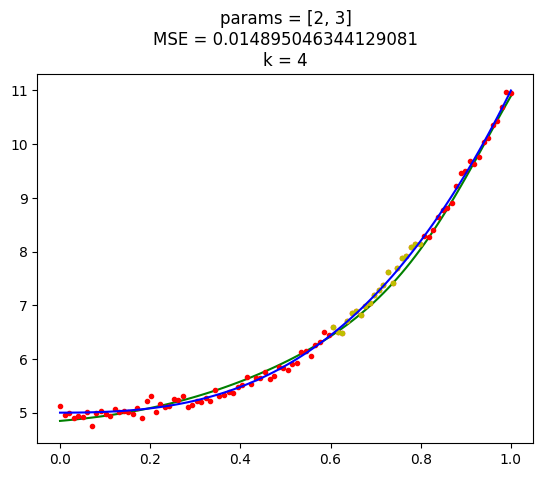

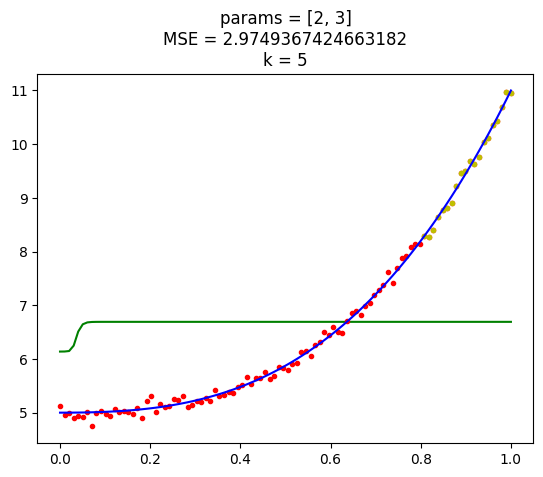

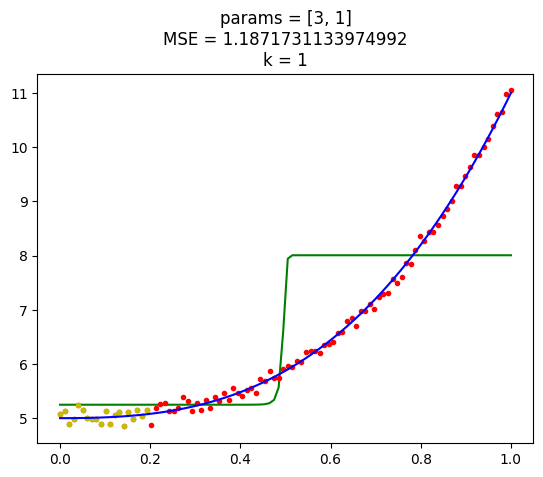

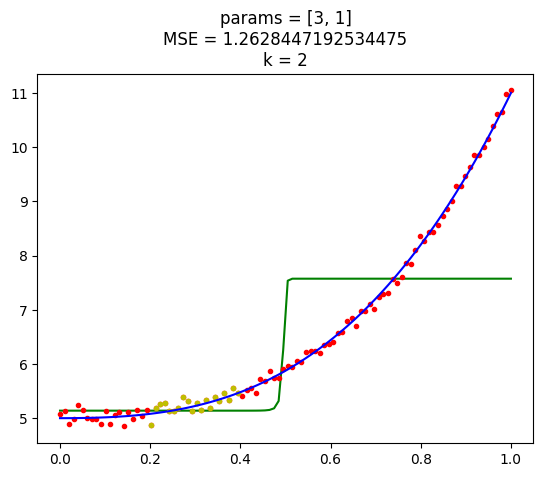

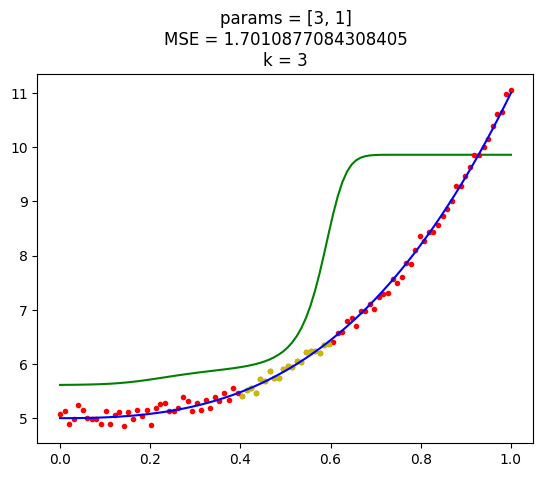

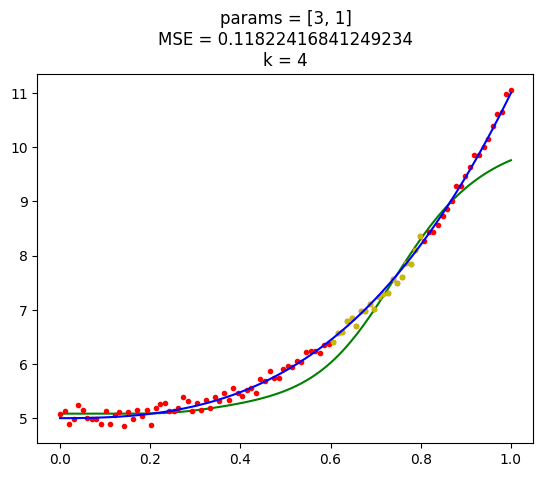

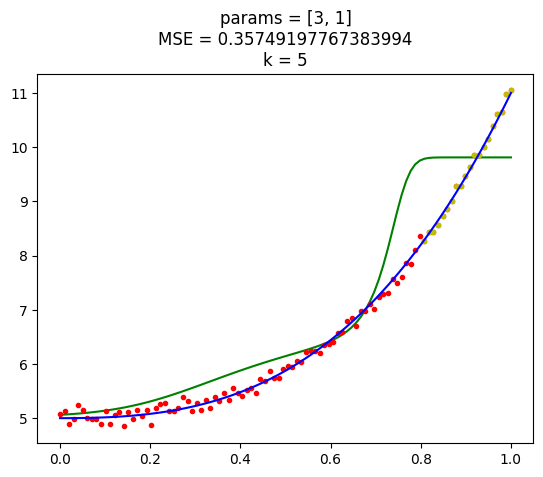

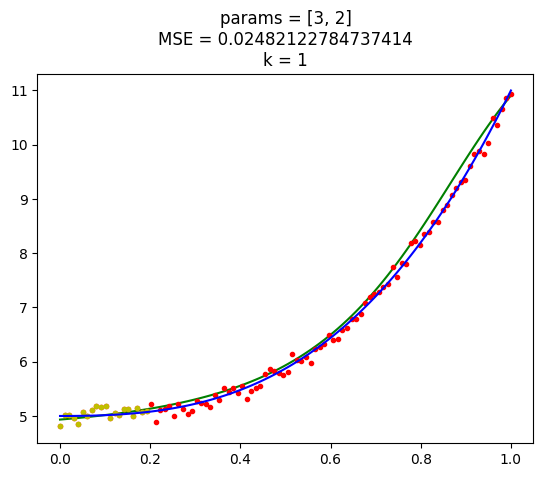

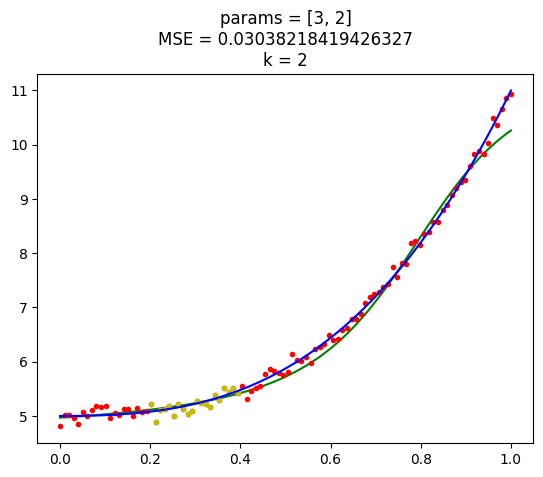

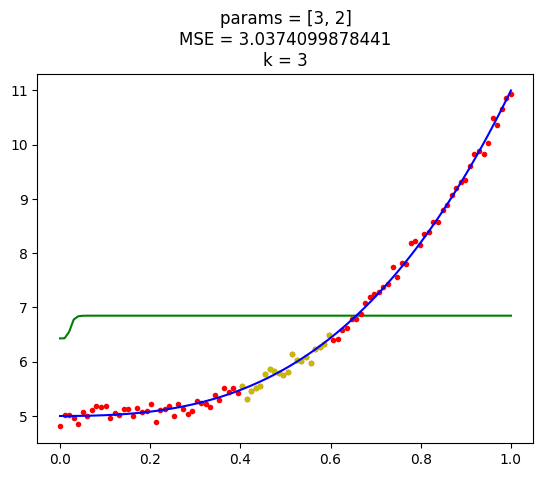

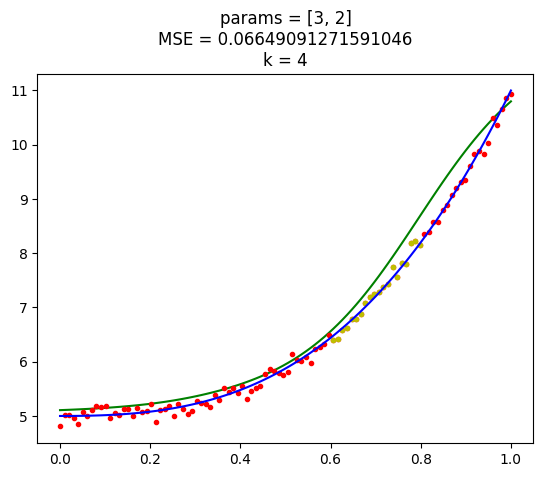

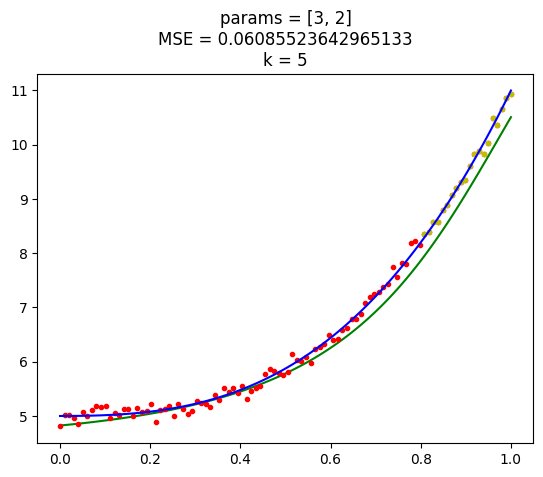

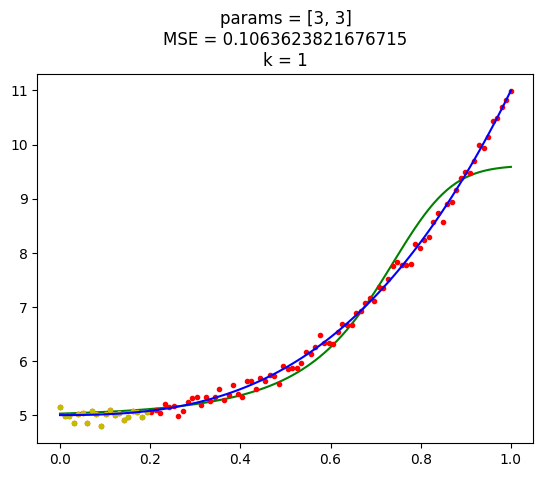

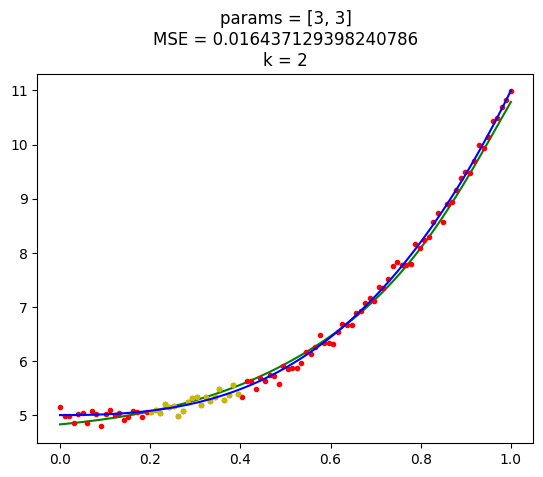

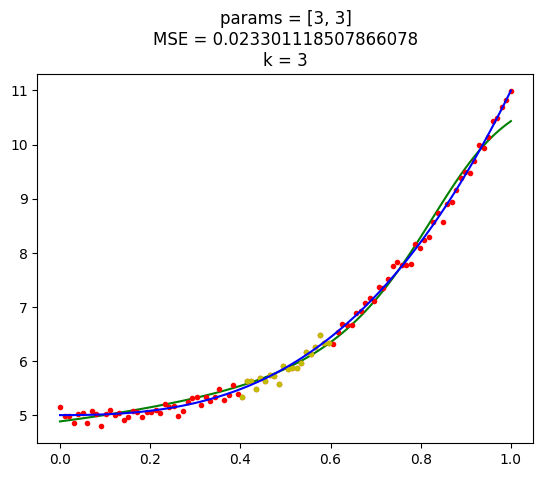

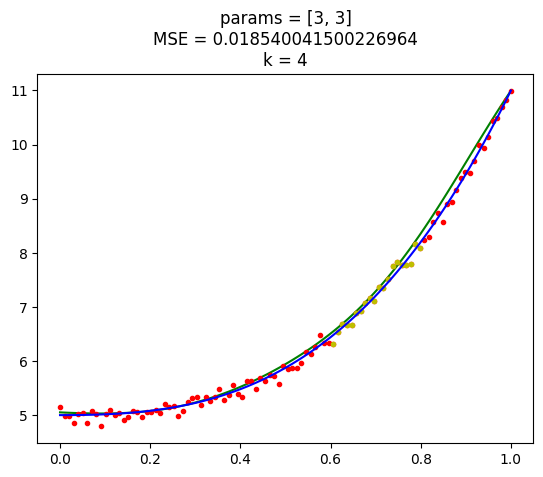

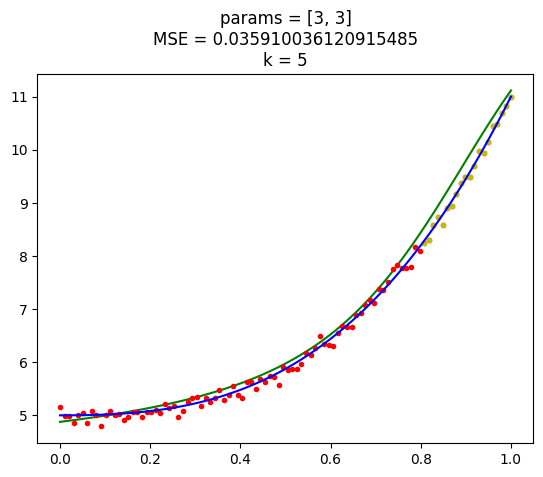

In [13]:
from sklearn.metrics import mean_squared_error

results = []

for param in params:
    k = 1
    avg_mean_squared_error = []
    y, y_noised = get_normal_noised_func_value('poly', x, 0, 0.1)
    y_noised_parts = np.array_split(y_noised, 5)
    
    for k in range(len(x_parts)):
        model = Perceptron(
            rate=0.1,
            layers_params=param,
            epoch_count=200,
            batch_size=20
        )
        
        model.fit([[v] for v in x], [[v] for v in y_noised])
        res = model.predict([[v] for v in x])
        y_pred = [[v][0] for v in res]
        y_pred_parts = np.array_split(y_pred, 5)
        
        plt.title('params = ' + str(param) + '\n' + 'MSE = ' + str(mean_squared_error(y_noised, y_pred)) + '\n' + "k = " + str(k+1))
        
        avg_mean_squared_error.append(mean_squared_error(y_noised_parts[k], y_pred_parts[k]))
        
        plt.plot(x, y_pred, 'g-')
        plt.plot(x, y_noised, 'r.')
        plt.plot(x_parts[k], y_noised_parts[k], 'y.')
        plt.plot(x, y, 'b-')
        plt.show()
        
    results.append((param, np.average(avg_mean_squared_error)))

In [14]:
for t in (sorted(results, key=lambda t: t[1])):
    print('Layer Params = ', t[0], ' Error = ', t[1])

Layer Params =  [3, 3]  Error =  0.029546343939825016
Layer Params =  [2, 1]  Error =  0.0749421132316744
Layer Params =  [3, 2]  Error =  0.2544621369570407
Layer Params =  [1, 3]  Error =  0.2770527062310715
Layer Params =  [3]  Error =  0.30125794599336014
Layer Params =  [3, 1]  Error =  0.32933982885270935
Layer Params =  [2, 2]  Error =  0.5544067338151347
Layer Params =  [2, 3]  Error =  1.790315607310505
Layer Params =  [1]  Error =  2.0202260168306716
Layer Params =  [1, 1]  Error =  2.0508296561768526
Layer Params =  [2]  Error =  3.250351298500081
Layer Params =  [1, 2]  Error =  3.6681461275314753


Синус

In [15]:
# results = []
# 
# for param in params:
#     
#     model = Perceptron(
#         rate=0.01,
#         layers_params=param,
#         epoch_count=1000,
#         batch_size=100
#     )
#     
#     y, y_noised = get_normal_noised_func_value('sin', x, 0, 0.1)
#     model.fit([[v] for v in x], [[v] for v in y_noised])
#     res = model.predict([[v] for v in x])
#     y_pred = [[v][0] for v in res]
#     
#     plt.title('params = ' + str(param) + '\n' + 'MSE = ' + str(mean_squared_error(y_noised, y_pred)))
#     plt.plot(x, y_pred, 'g-')
#     plt.plot(x, y_noised, 'r.')
#     plt.plot(x, y, 'b-')
#     plt.show()
#     
#     results.append((param, mean_squared_error(y_noised, y_pred)))

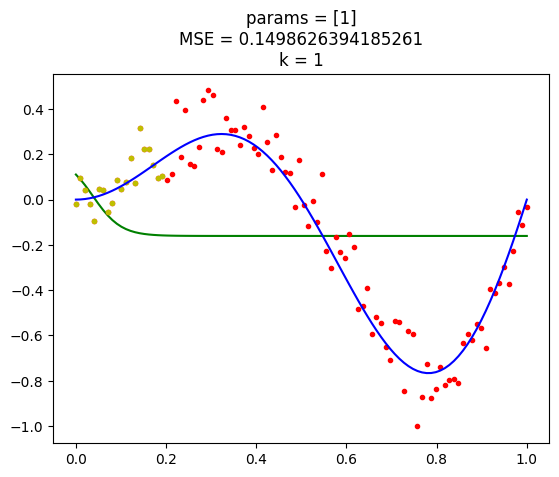

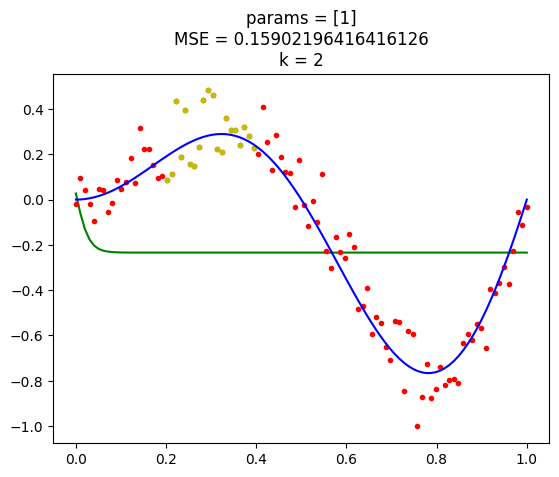

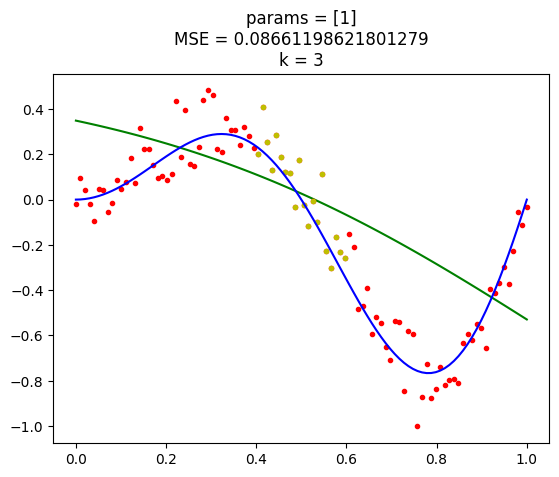

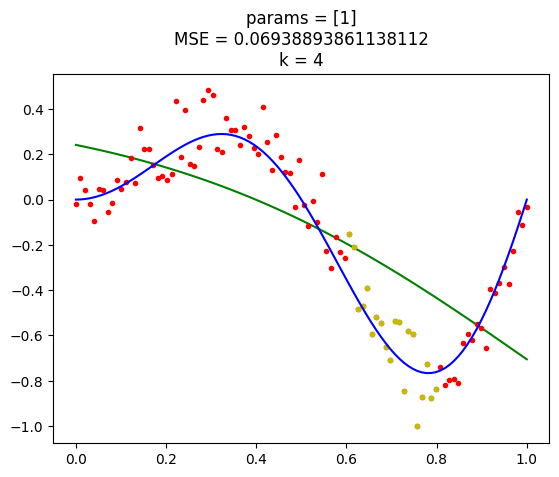

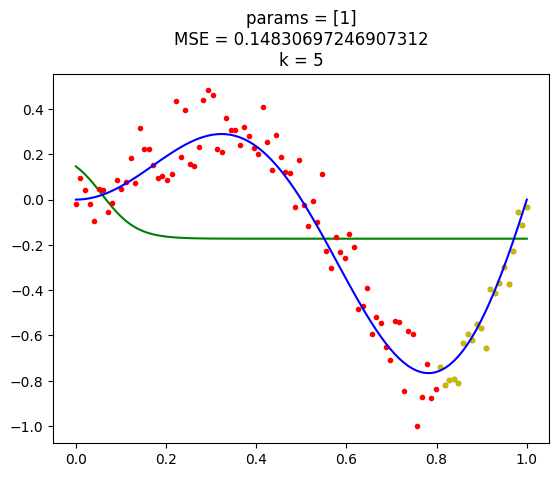

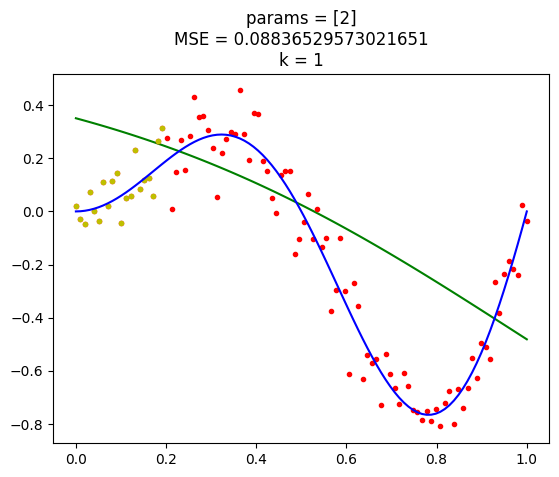

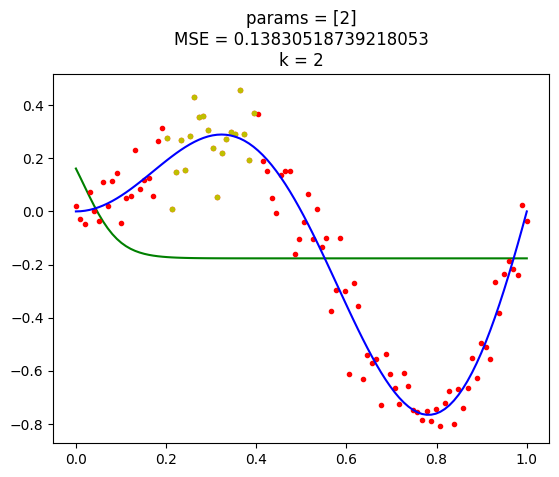

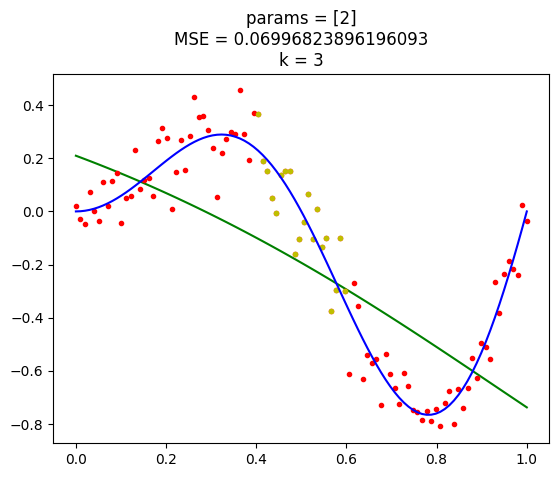

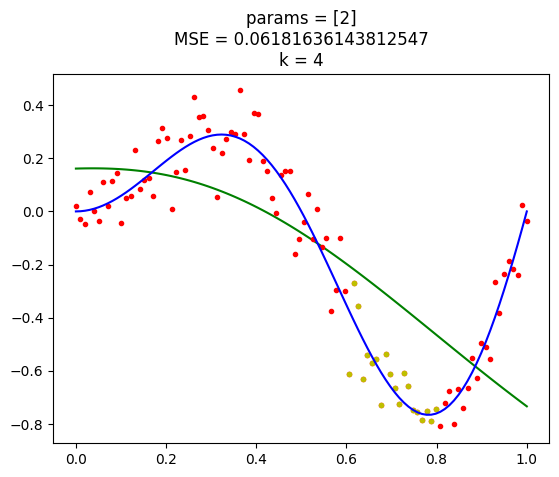

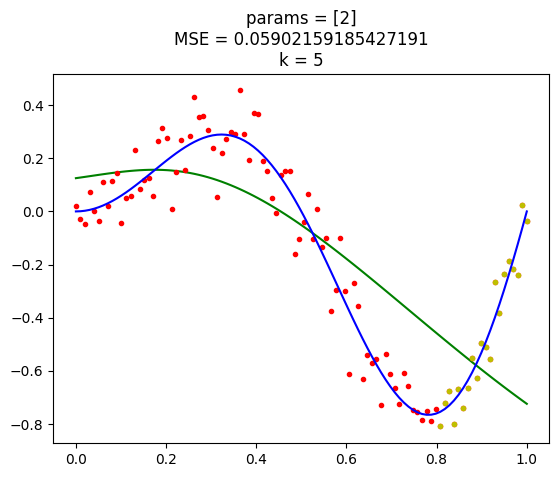

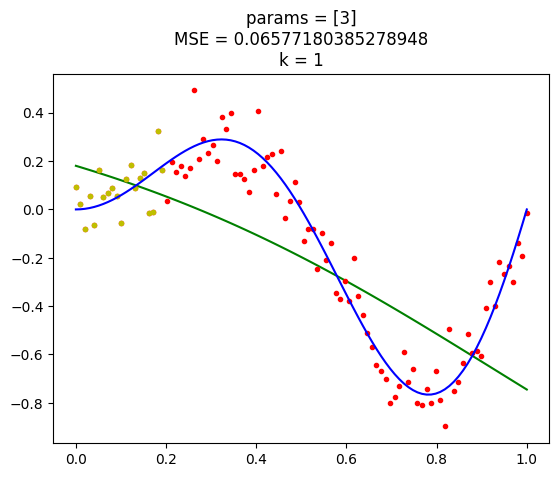

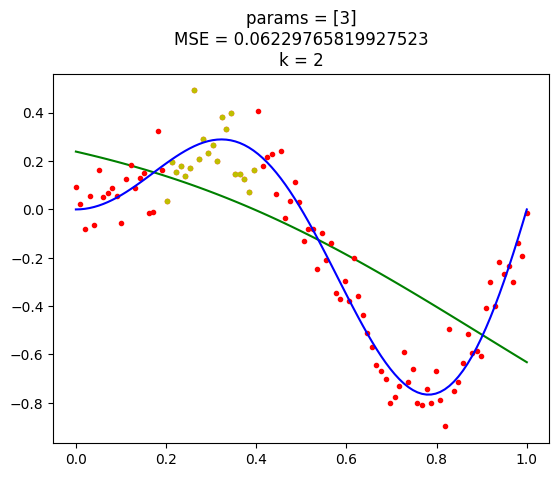

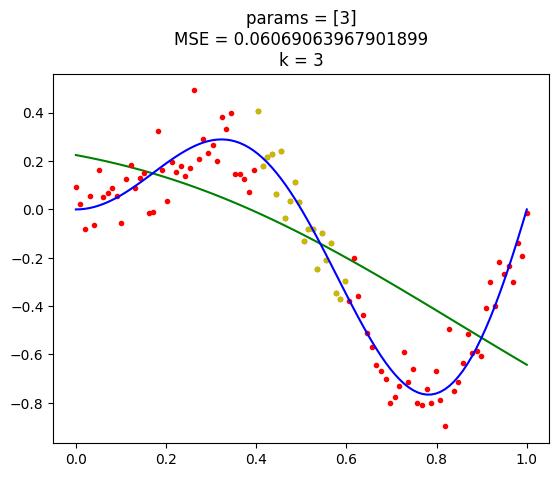

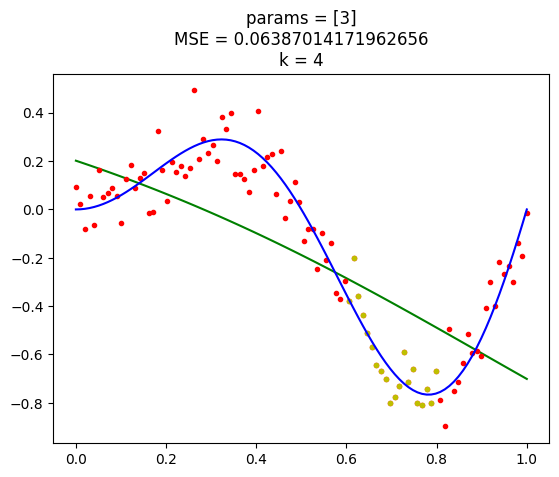

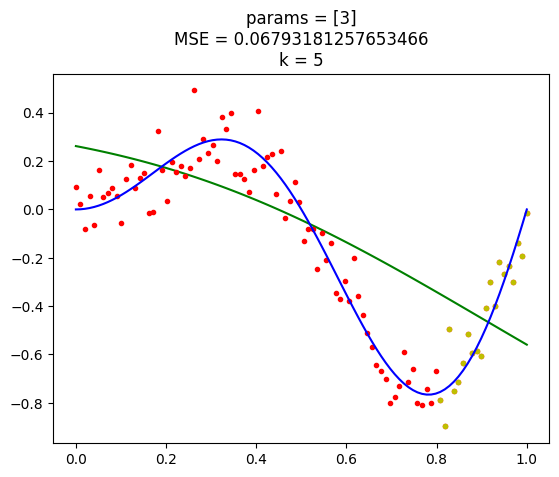

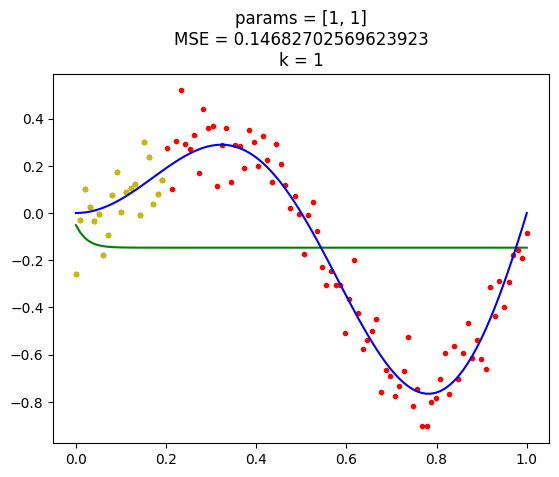

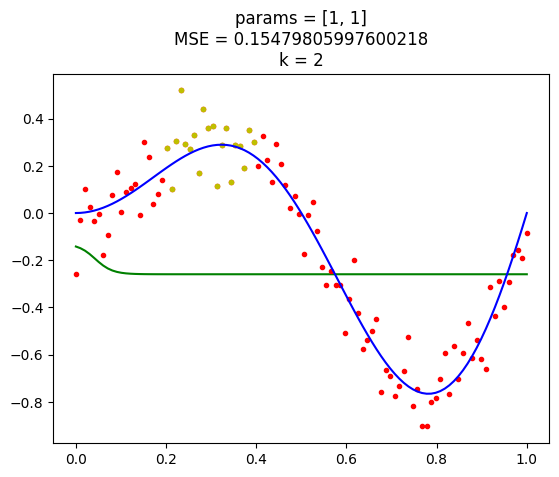

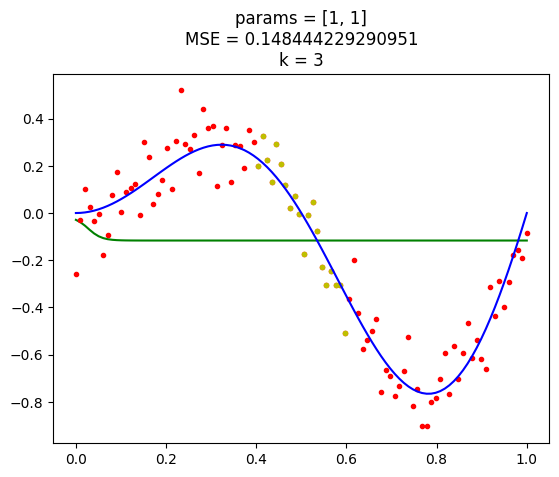

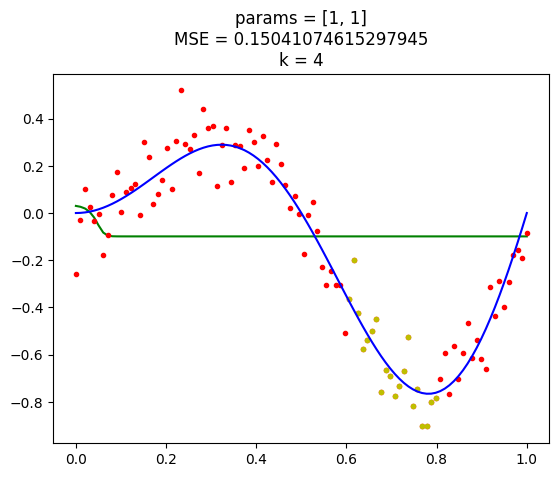

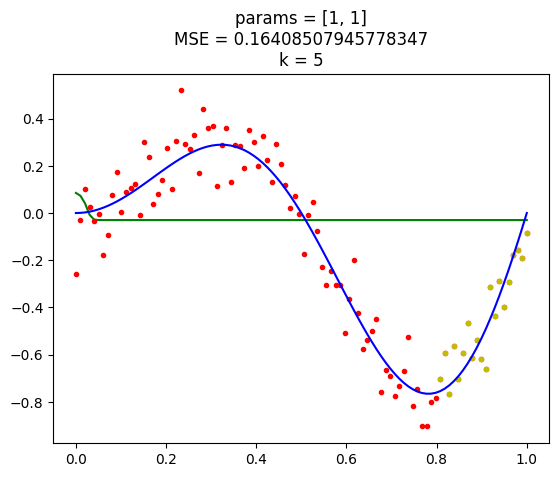

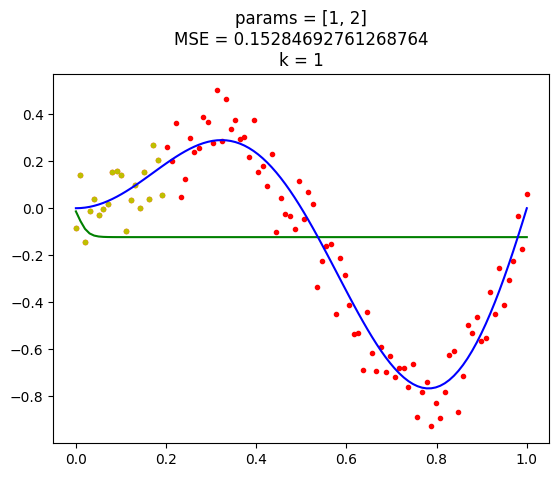

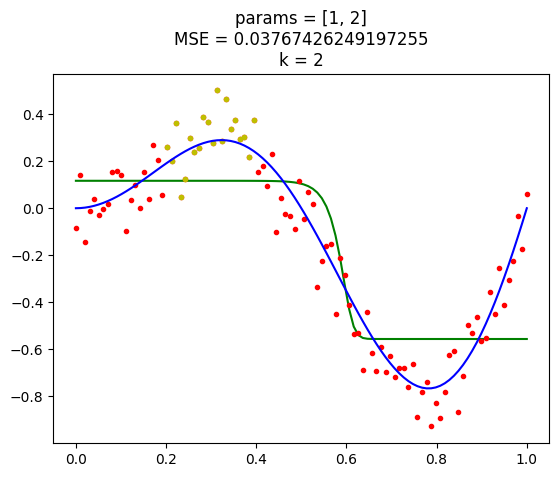

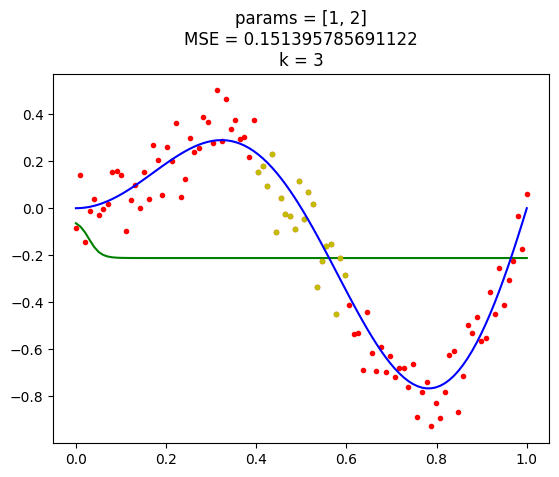

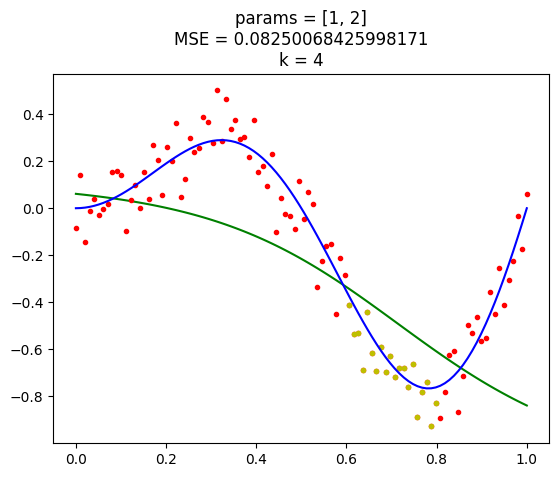

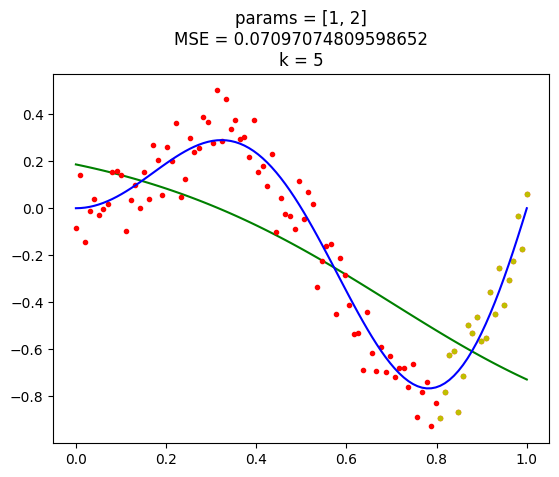

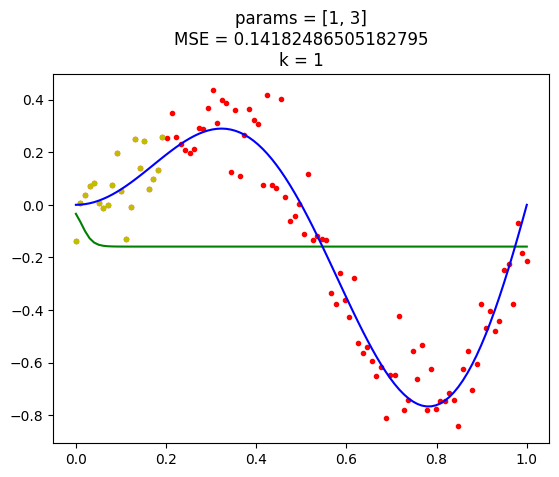

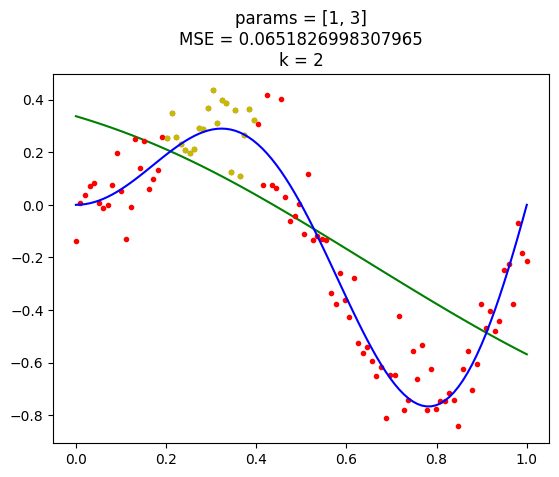

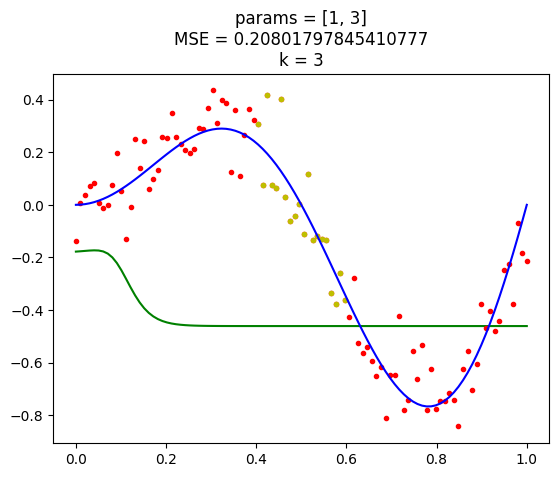

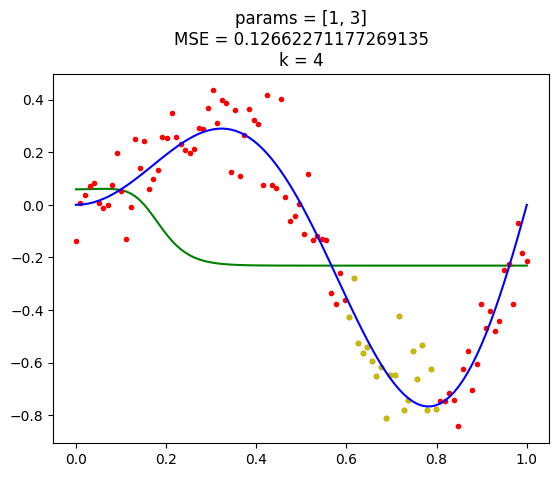

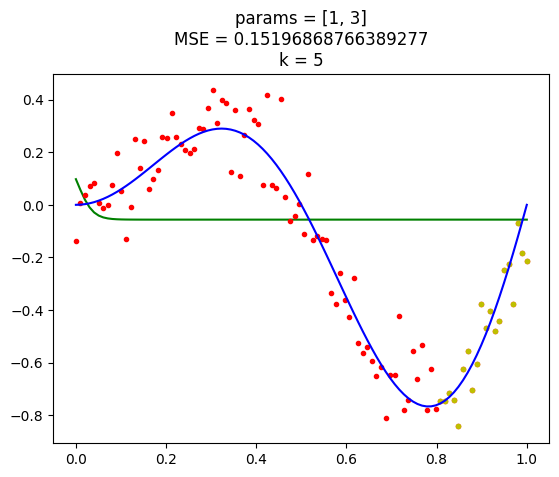

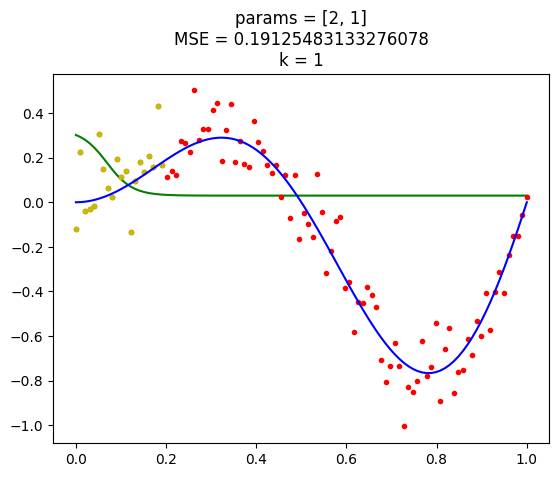

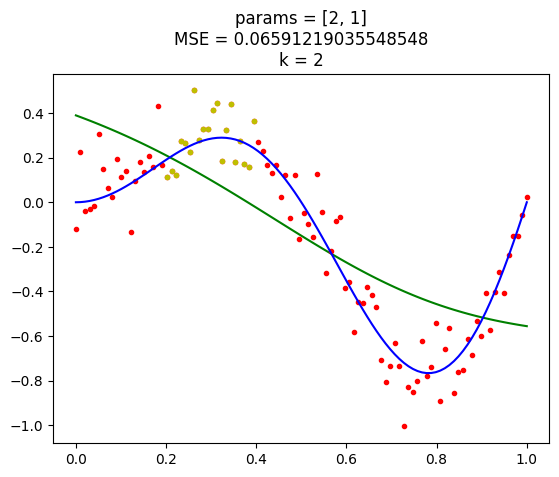

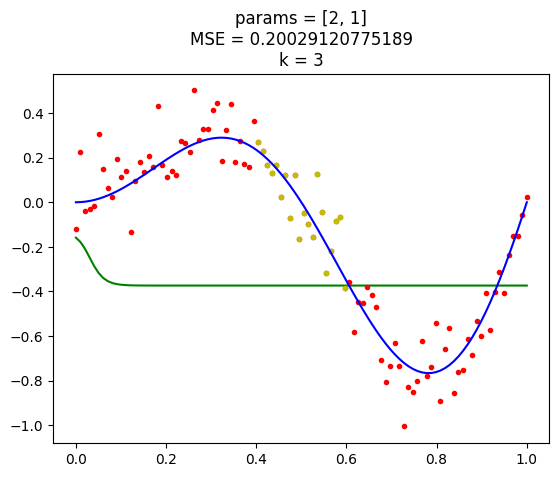

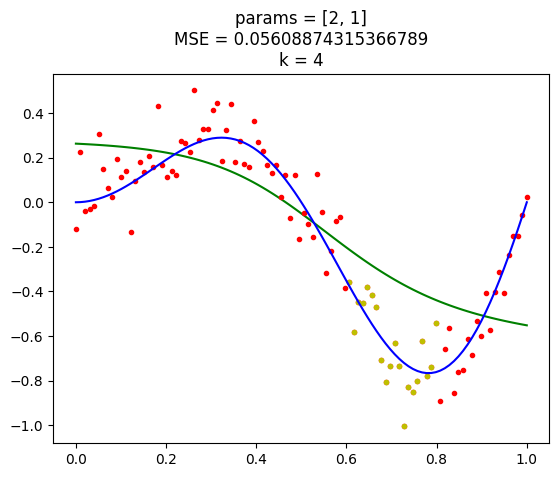

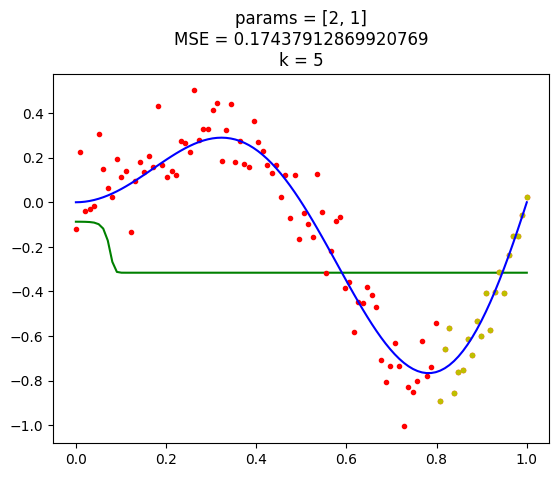

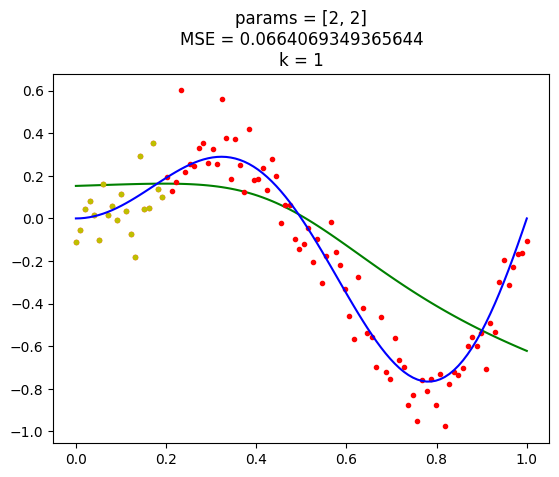

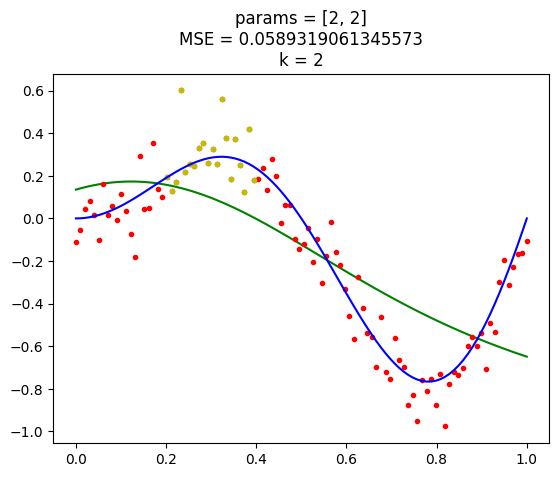

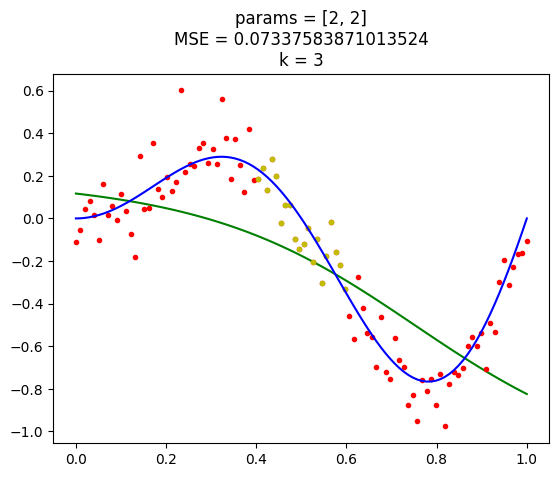

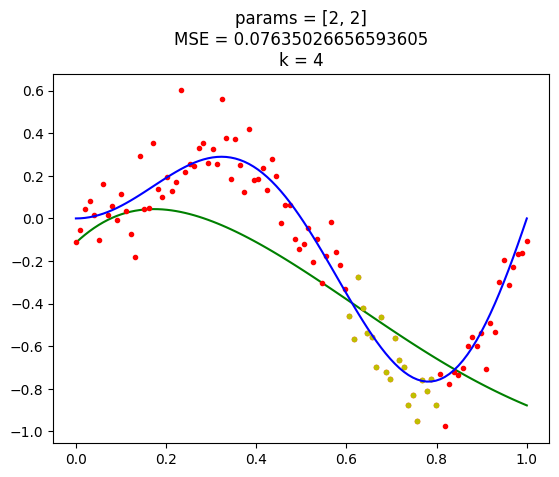

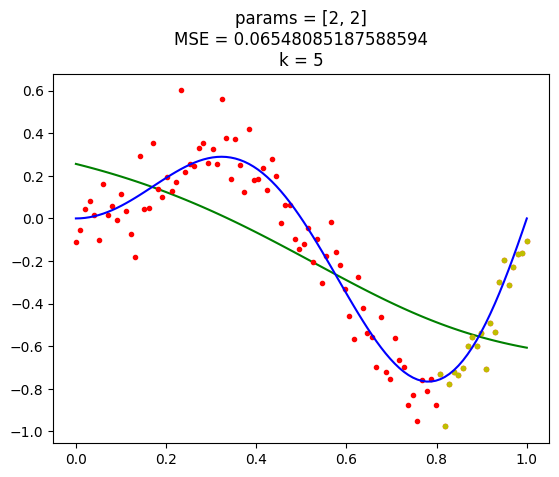

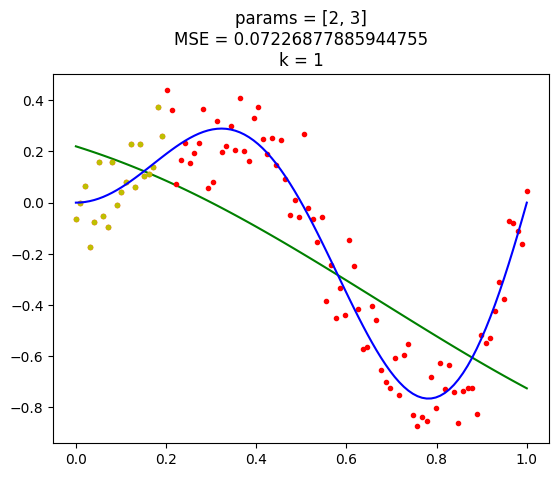

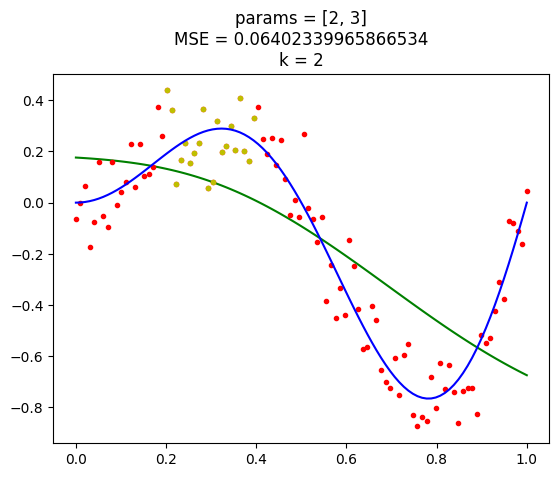

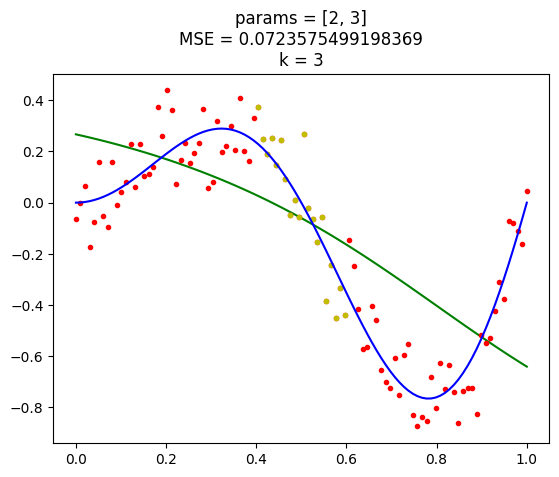

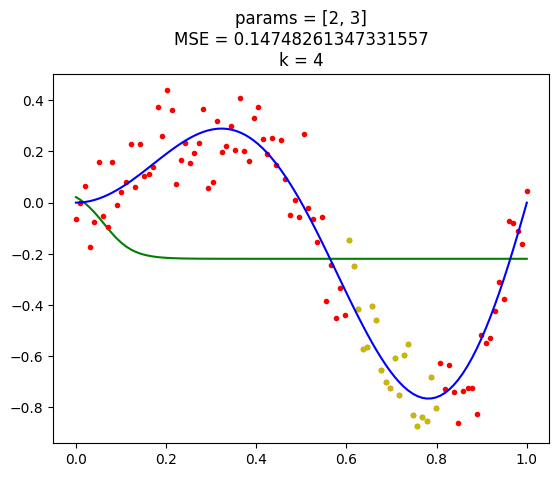

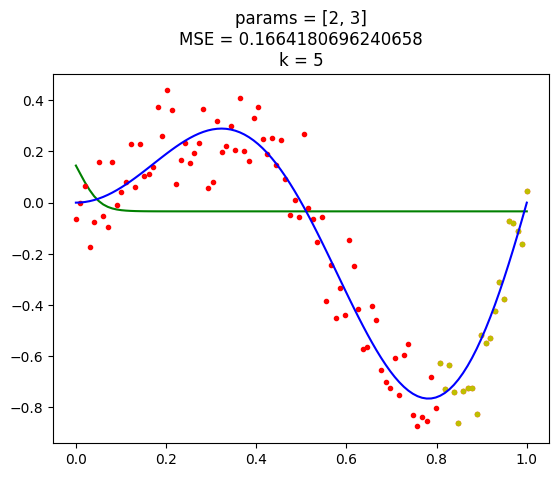

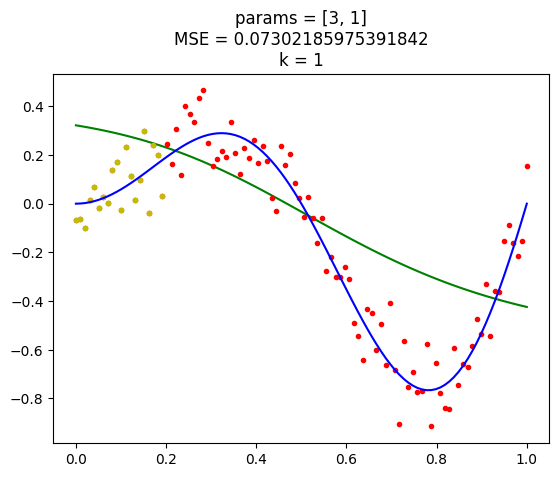

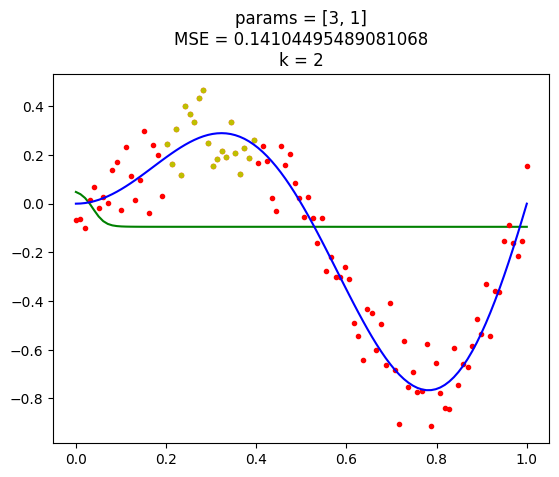

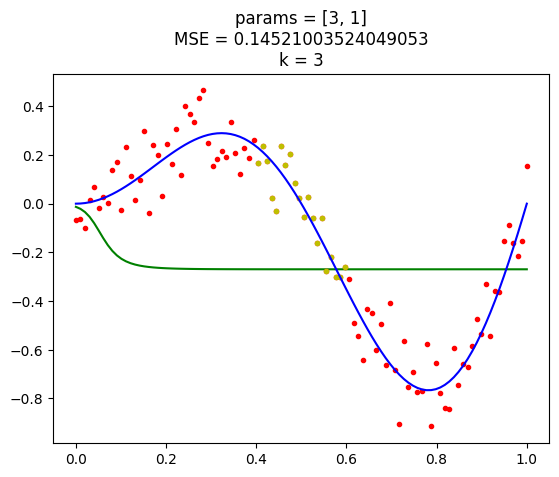

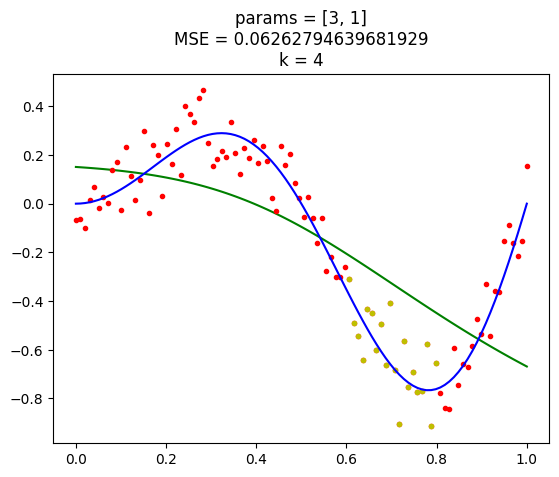

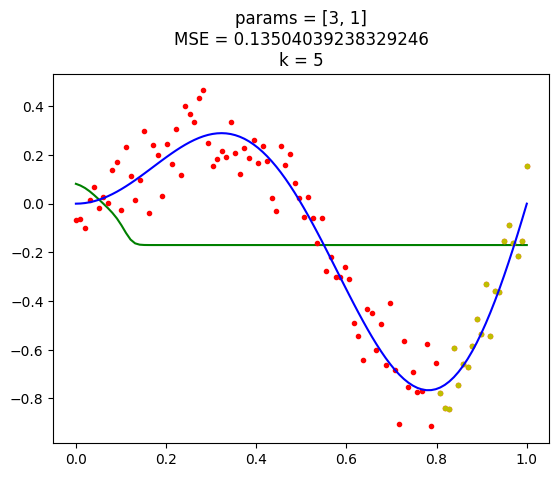

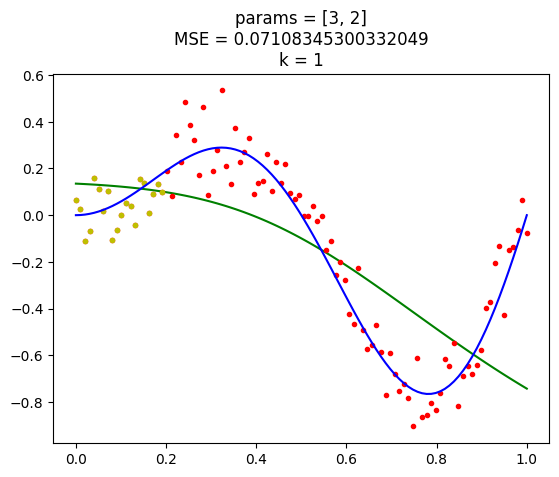

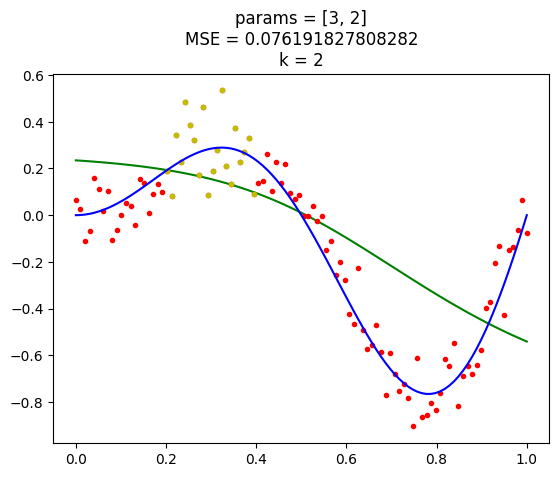

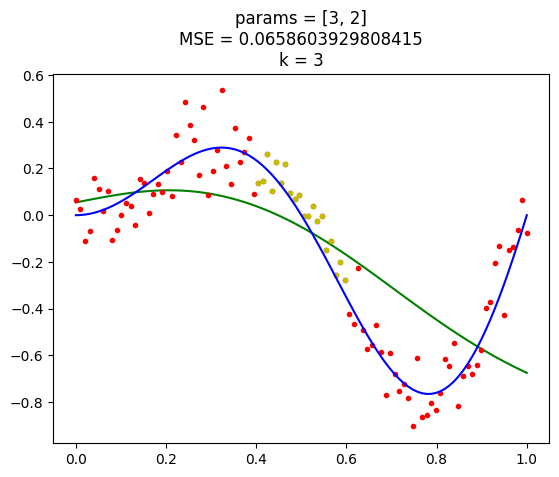

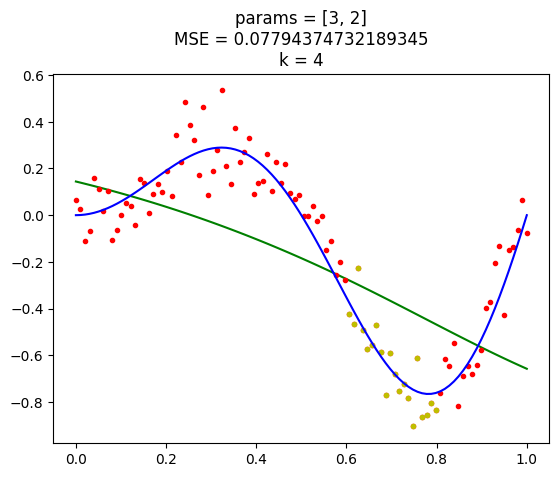

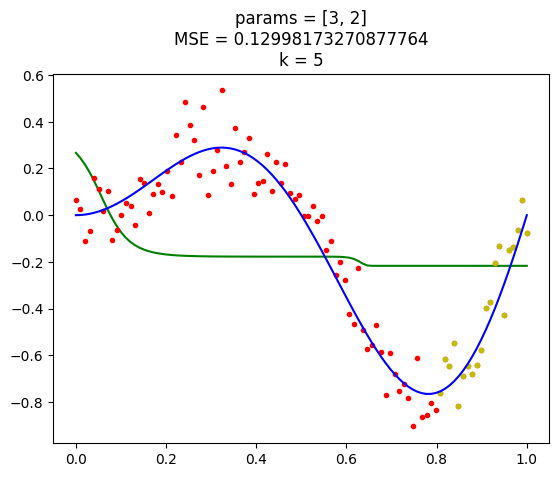

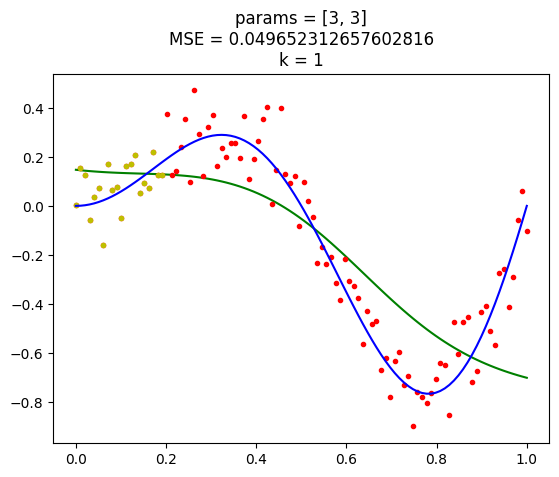

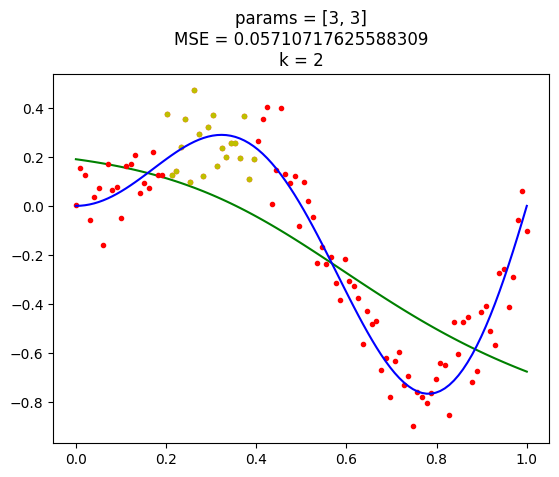

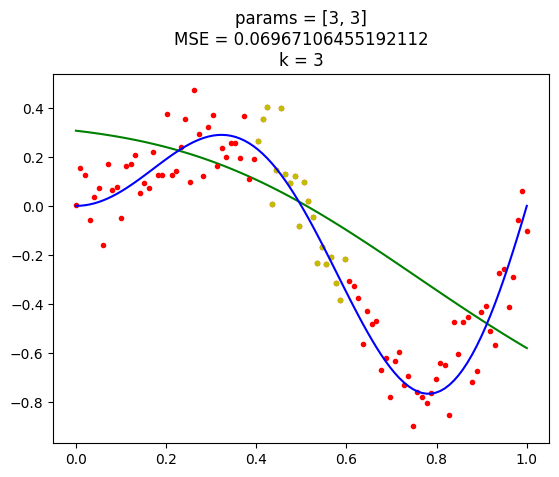

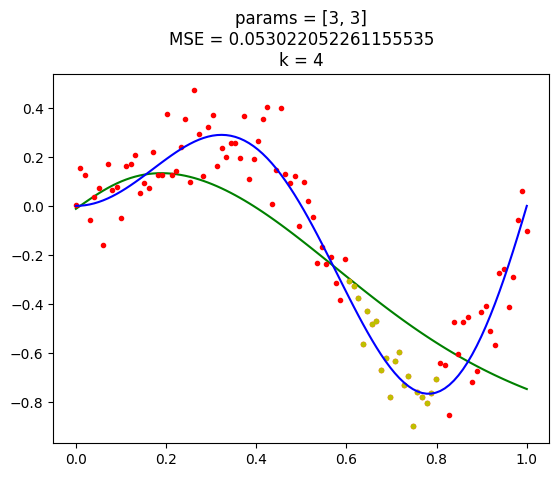

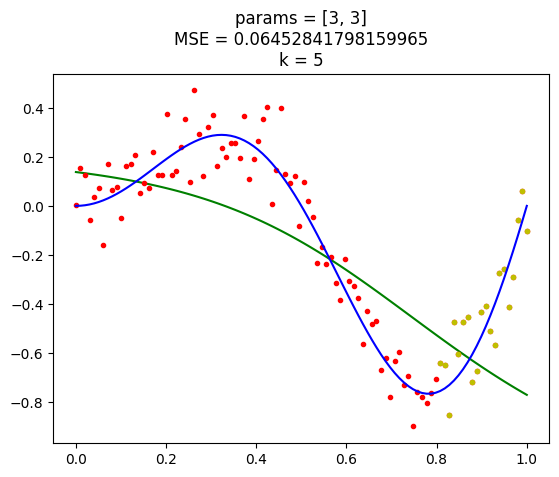

In [16]:
from sklearn.metrics import mean_squared_error

results = []

for param in params:
    k = 1
    avg_mean_squared_error = []
    y, y_noised = get_normal_noised_func_value('sin', x, 0, 0.1)
    y_noised_parts = np.array_split(y_noised, 5)
    
    for k in range(len(x_parts)):
        model = Perceptron(
            rate=0.1,
            layers_params=param,
            epoch_count=1000,
            batch_size=50
        )
        
        model.fit([[v] for v in x], [[v] for v in y_noised])
        res = model.predict([[v] for v in x])
        y_pred = [[v][0] for v in res]
        y_pred_parts = np.array_split(y_pred, 5)
        
        plt.title('params = ' + str(param) + '\n' + 'MSE = ' + str(mean_squared_error(y_noised, y_pred)) + '\n' + "k = " + str(k+1))
        
        avg_mean_squared_error.append(mean_squared_error(y_noised_parts[k], y_pred_parts[k]))
        
        plt.plot(x, y_pred, 'g-')
        plt.plot(x, y_noised, 'r.')
        plt.plot(x_parts[k], y_noised_parts[k], 'y.')
        plt.plot(x, y, 'b-')
        plt.show()
        
    results.append((param, np.average(avg_mean_squared_error)))

In [17]:
for t in (sorted(results, key=lambda t: t[1])):
    print('Layer Params = ', t[0], ' Error = ', t[1])

Layer Params =  [2, 2]  Error =  0.046238957134151194
Layer Params =  [3]  Error =  0.048581542813164444
Layer Params =  [3, 2]  Error =  0.053744236395009505
Layer Params =  [3, 3]  Error =  0.05457385945949198
Layer Params =  [1, 2]  Error =  0.06196922297623793
Layer Params =  [2, 1]  Error =  0.09183591090958014
Layer Params =  [2]  Error =  0.10786191884307306
Layer Params =  [3, 1]  Error =  0.10820795177113751
Layer Params =  [2, 3]  Error =  0.11688247438586137
Layer Params =  [1]  Error =  0.12565089707940552
Layer Params =  [1, 3]  Error =  0.1453891200749701
Layer Params =  [1, 1]  Error =  0.19486919783271162


Косинус

In [18]:
# results = []
# 
# for param in params:
#     
#     model = Perceptron(
#         rate=0.01,
#         layers_params=param,
#         epoch_count=1000,
#         batch_size=100
#     )
#     
#     y, y_noised = get_normal_noised_func_value('cos', x, 0, 0.1)
#     model.fit([[v] for v in x], [[v] for v in y_noised])
#     res = model.predict([[v] for v in x])
#     y_pred = [[v][0] for v in res]
#     
#     plt.title('params = ' + str(param) + '\n' + 'MSE = ' + str(mean_squared_error(y_noised, y_pred)))
#     plt.plot(x, y_pred, 'g-')
#     plt.plot(x, y_noised, 'r.')
#     plt.plot(x, y, 'b-')
#     plt.show()
#     
#     results.append((param, mean_squared_error(y_noised, y_pred)))

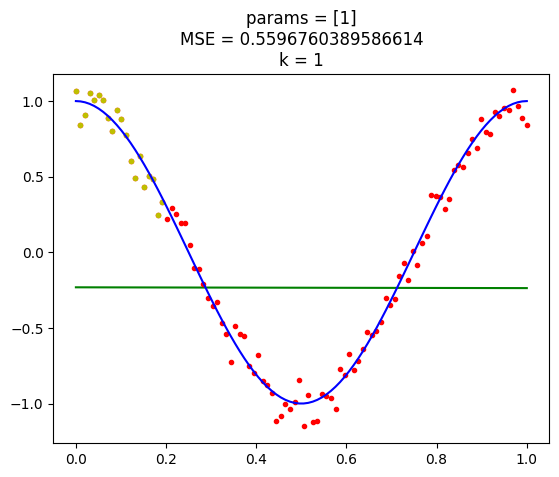

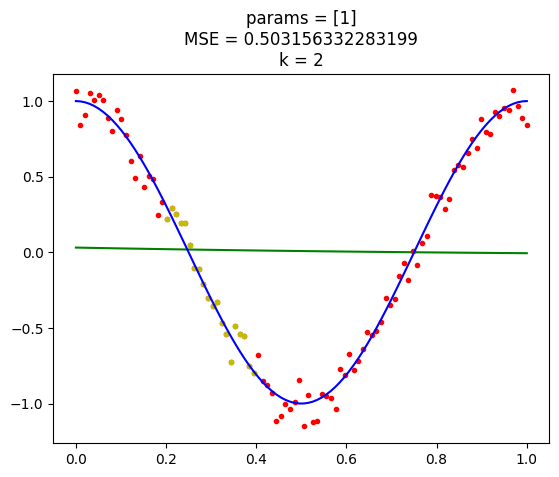

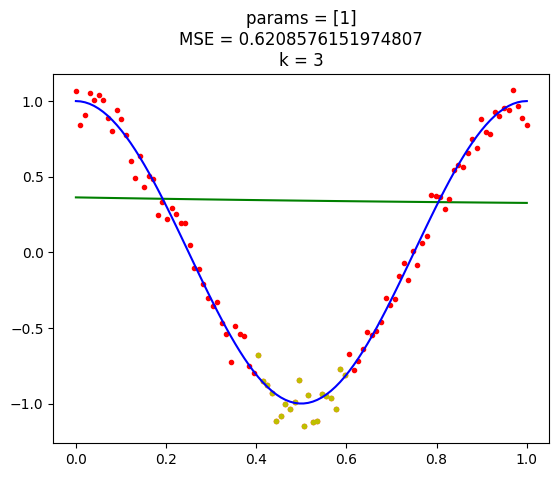

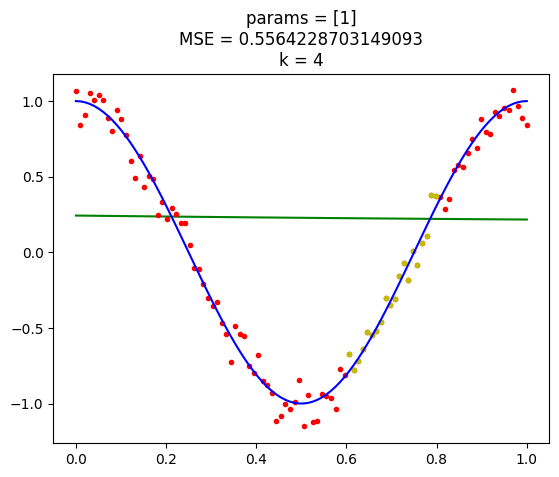

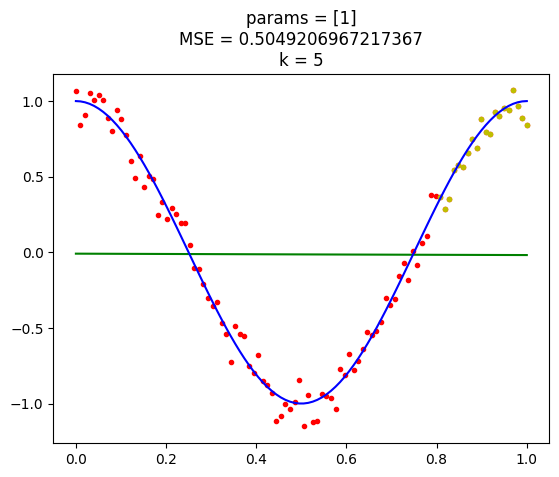

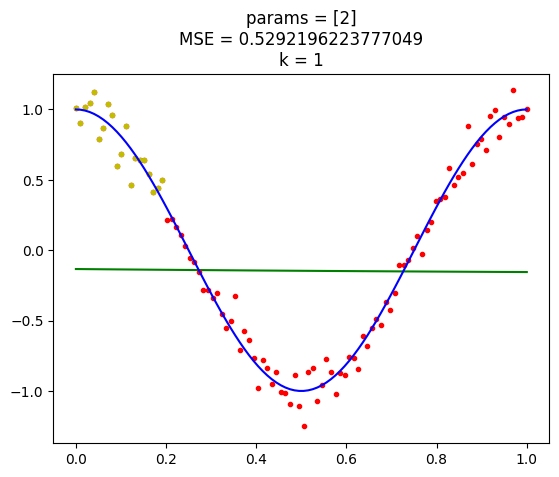

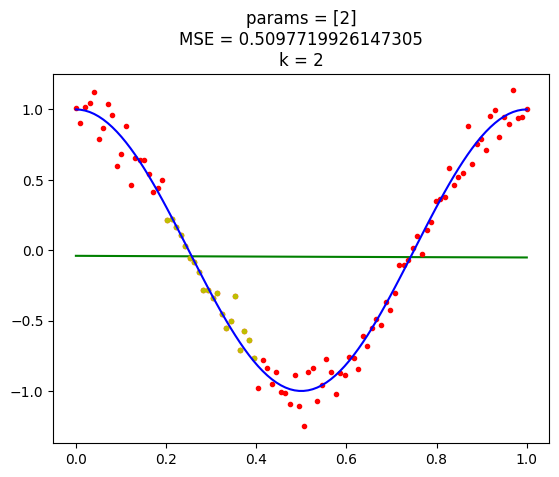

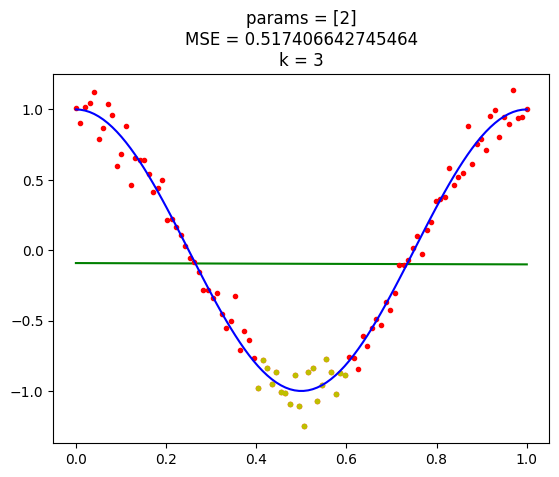

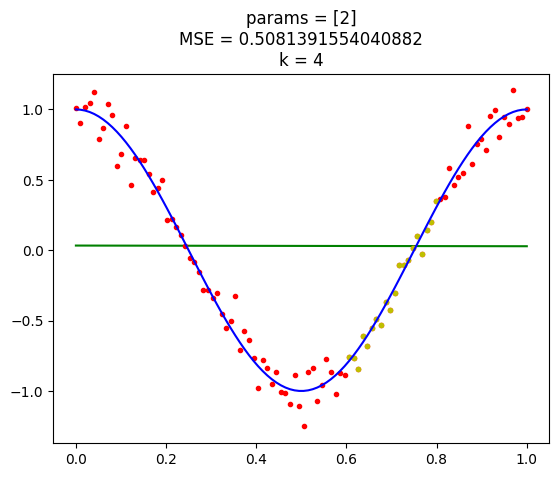

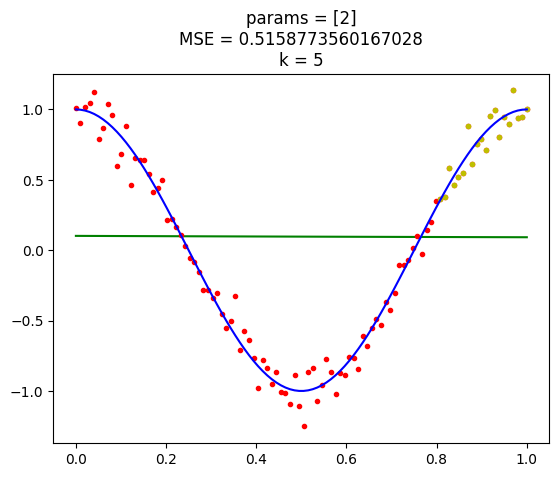

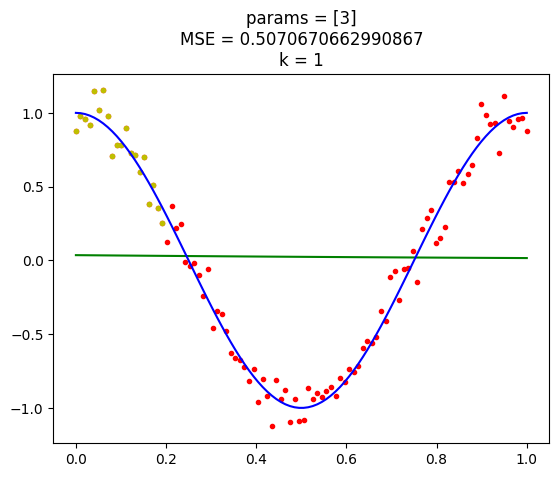

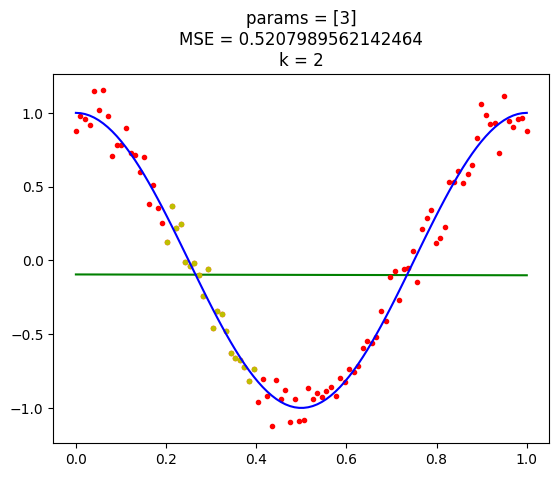

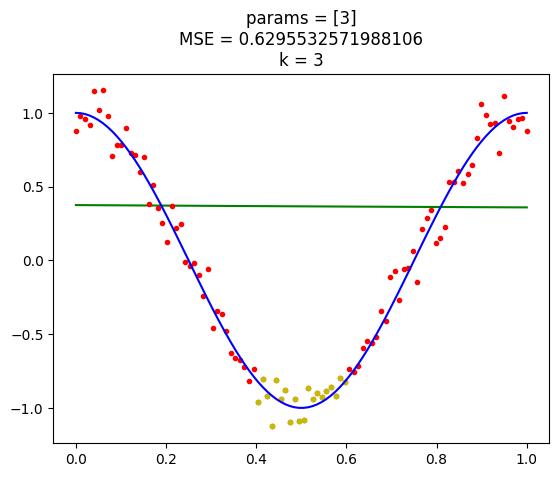

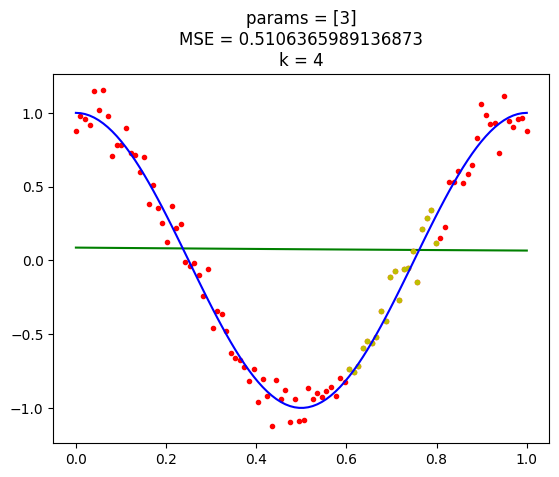

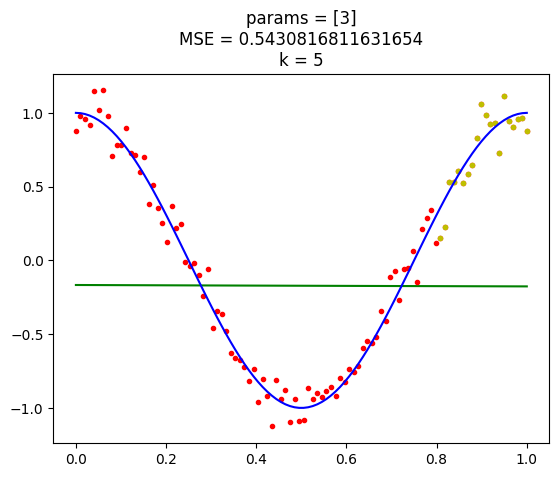

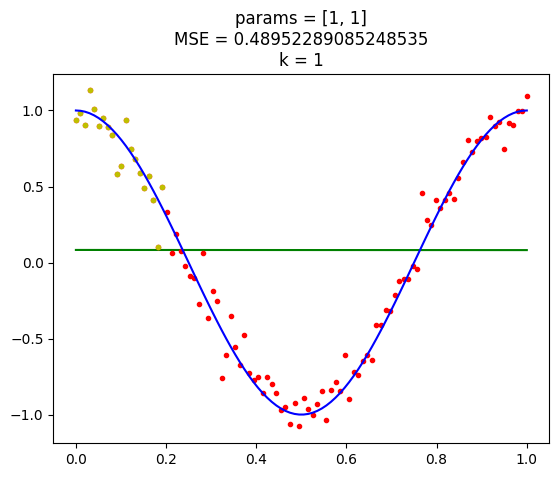

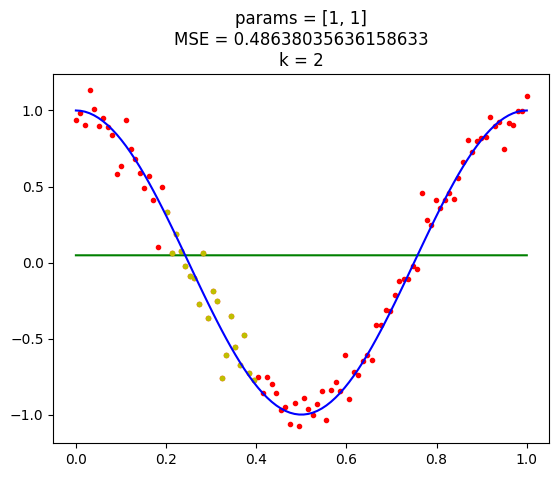

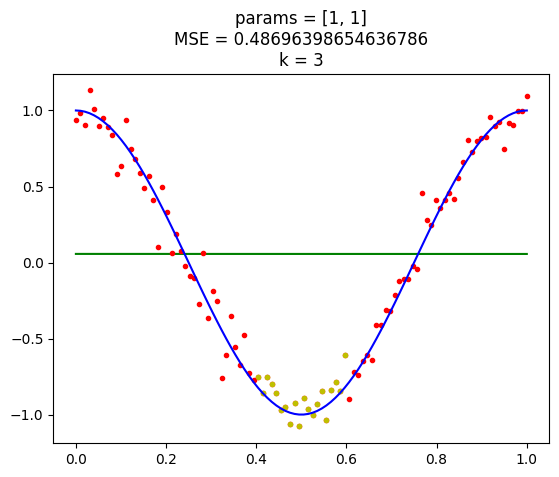

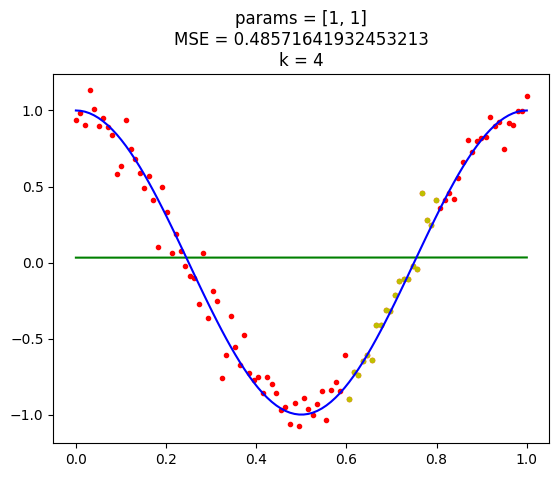

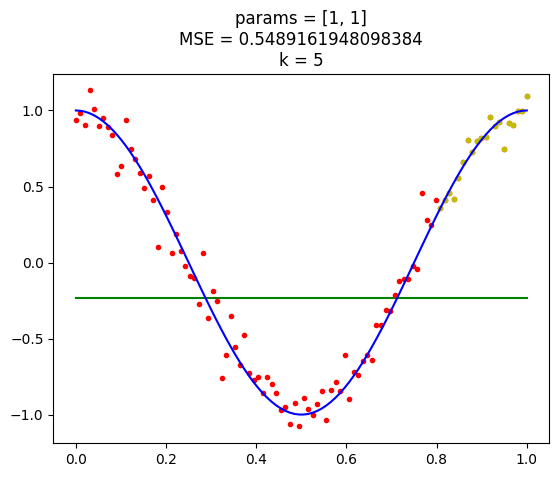

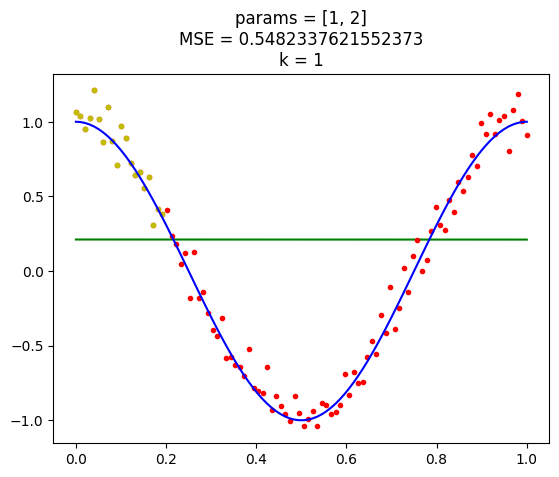

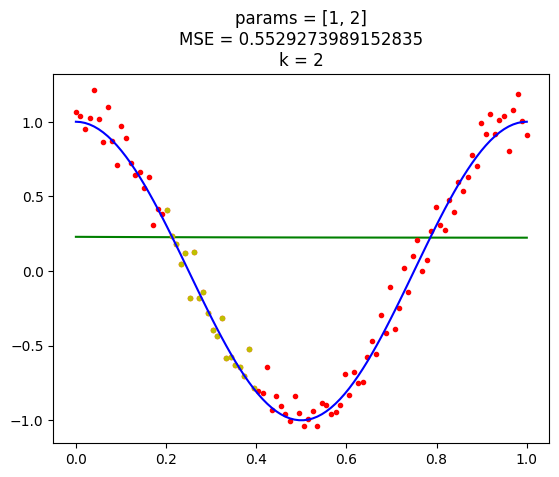

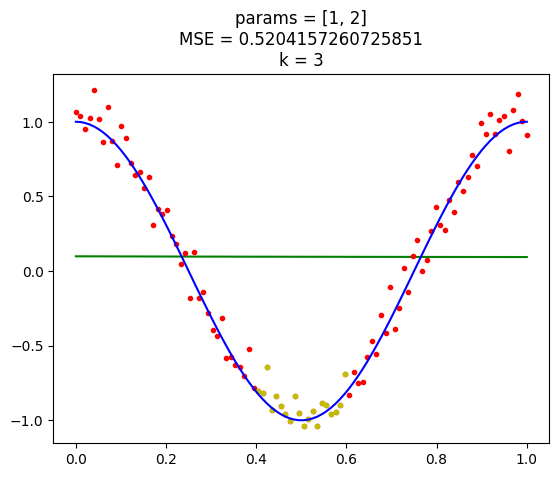

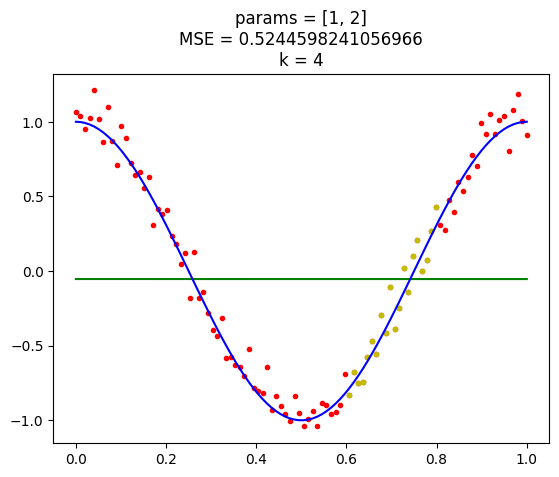

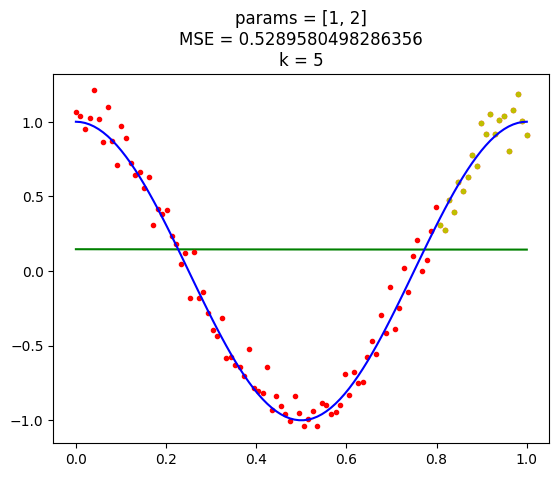

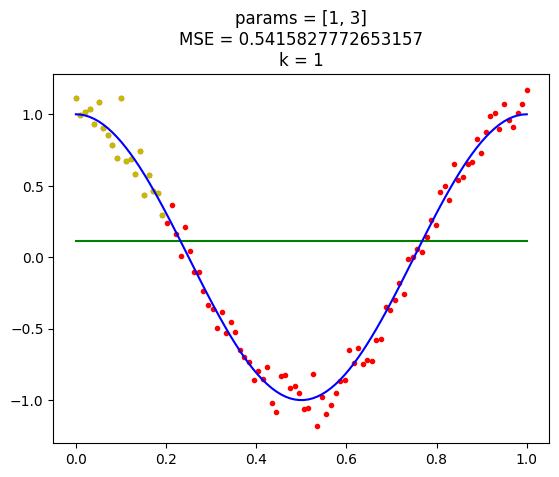

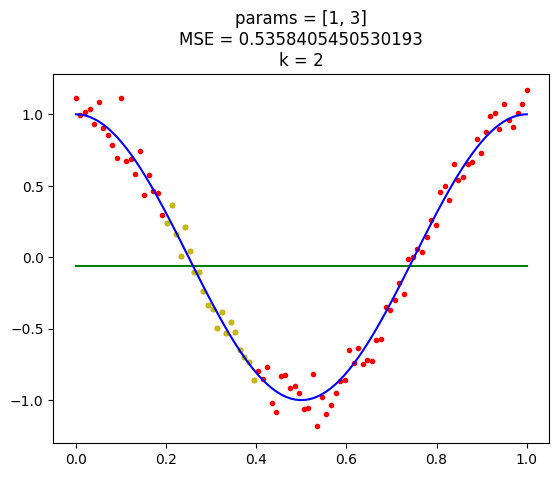

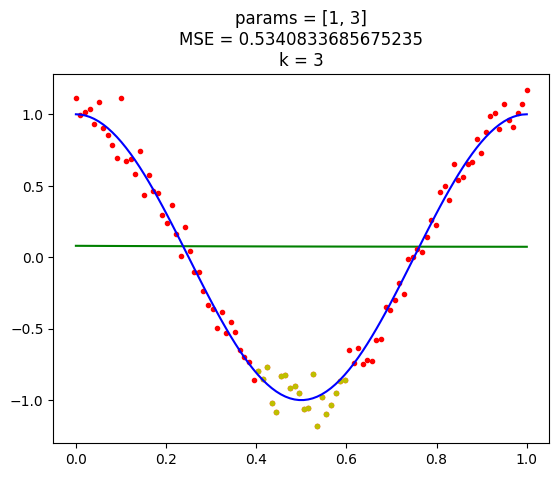

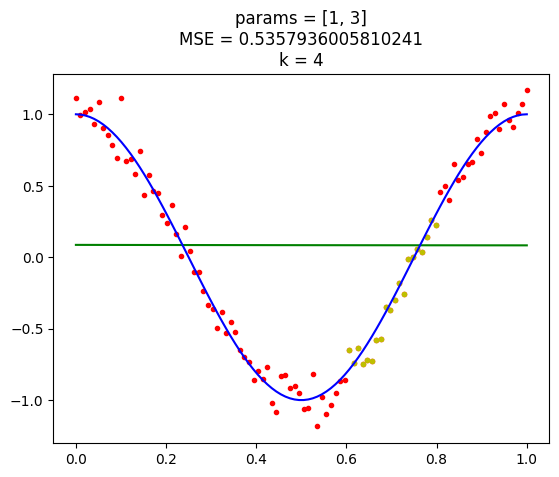

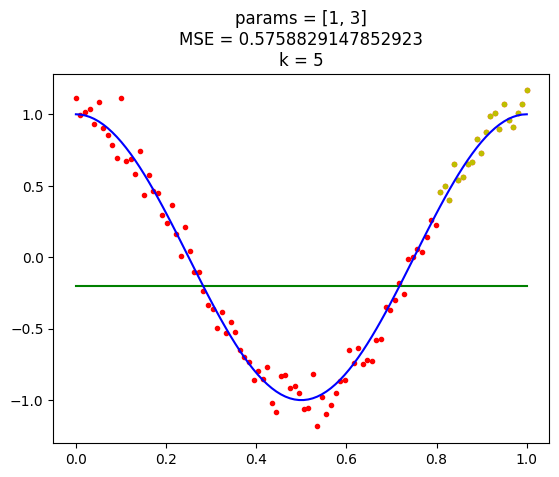

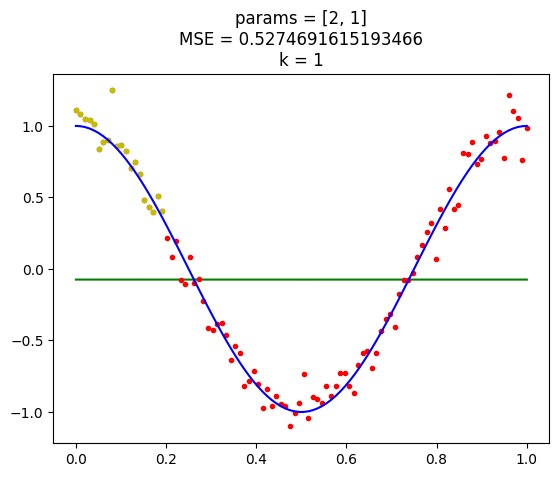

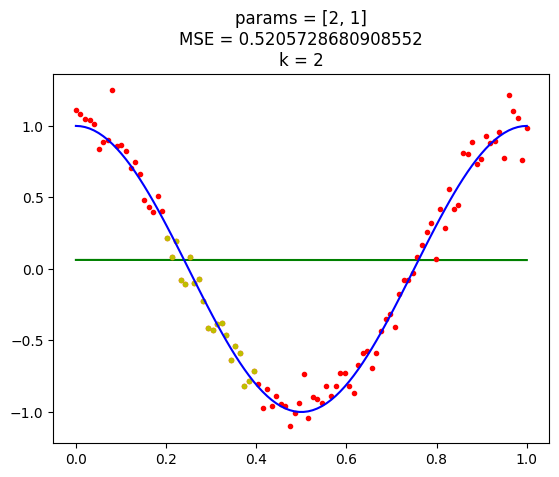

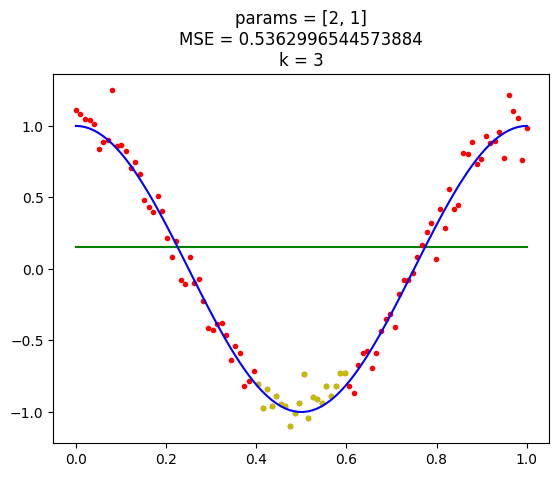

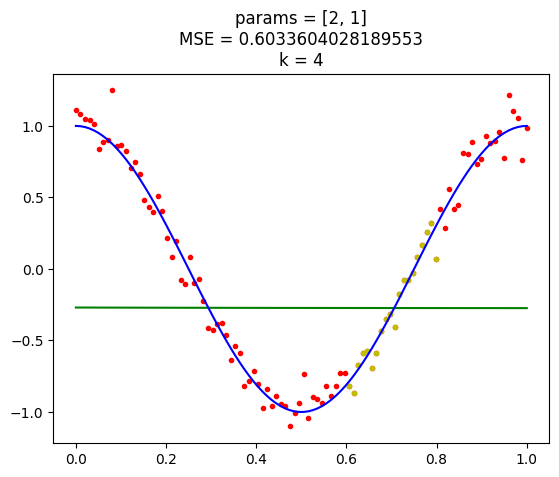

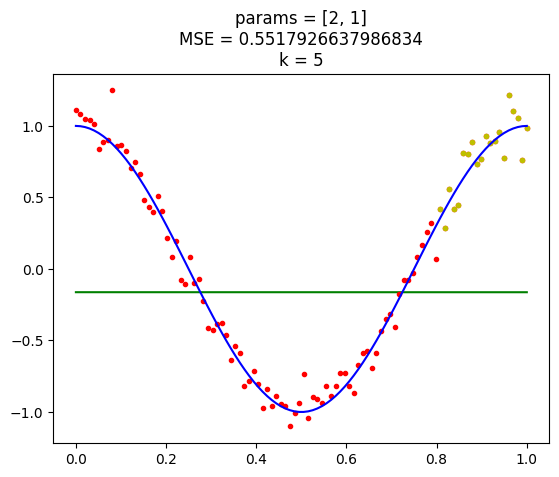

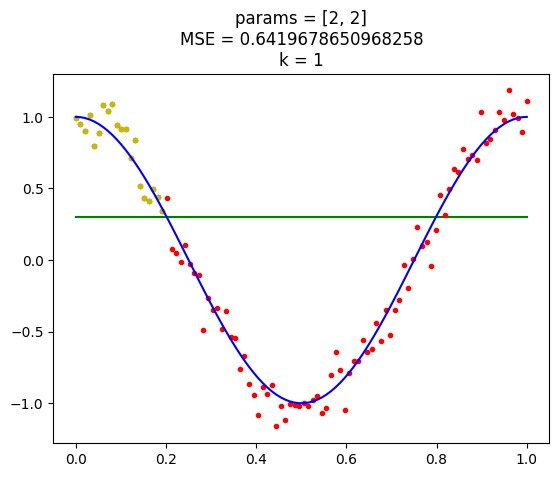

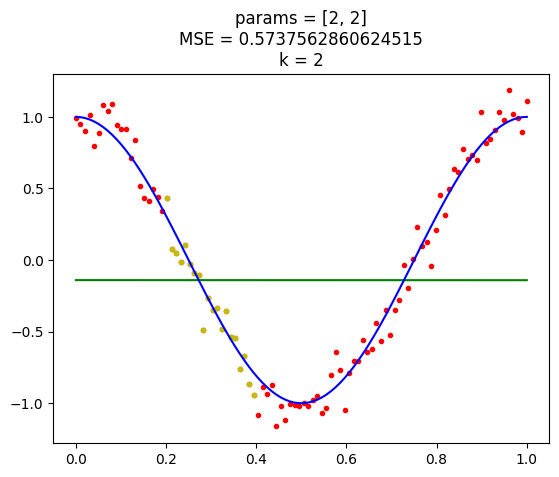

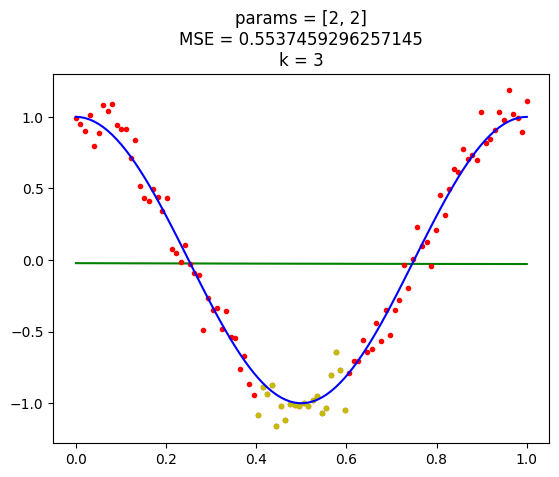

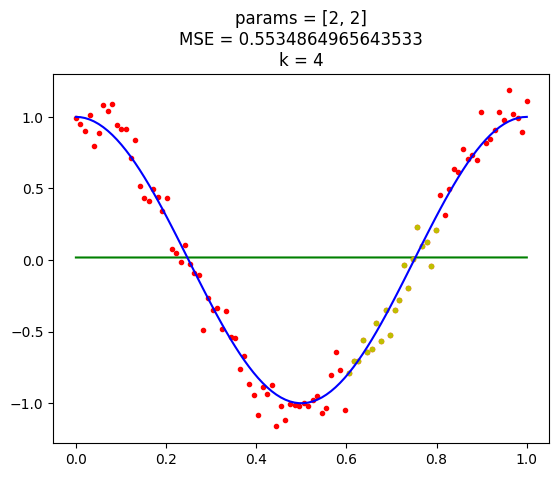

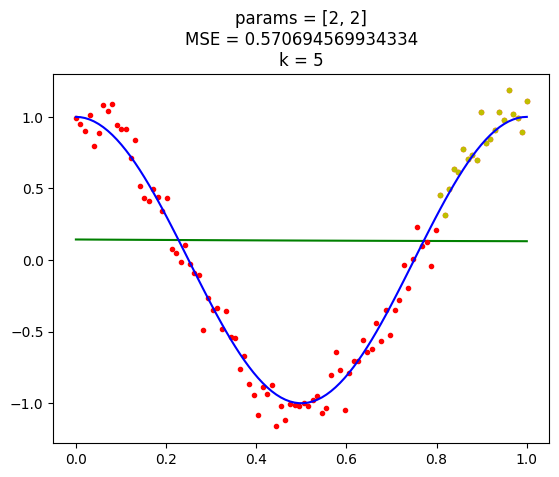

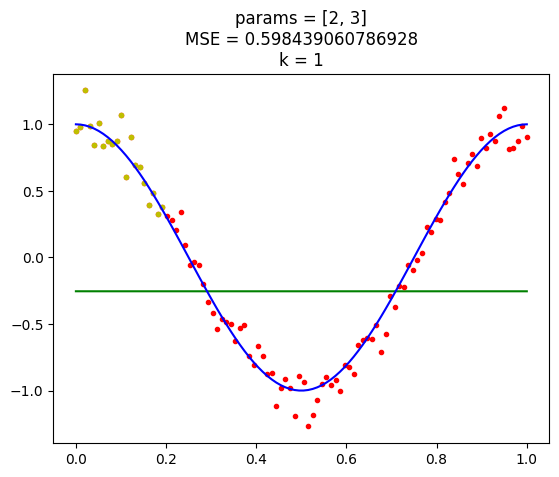

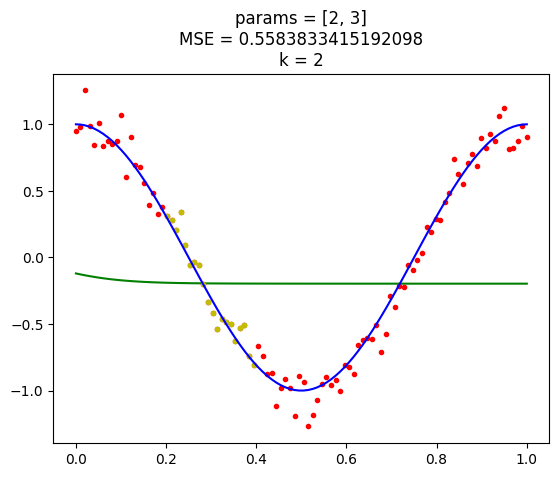

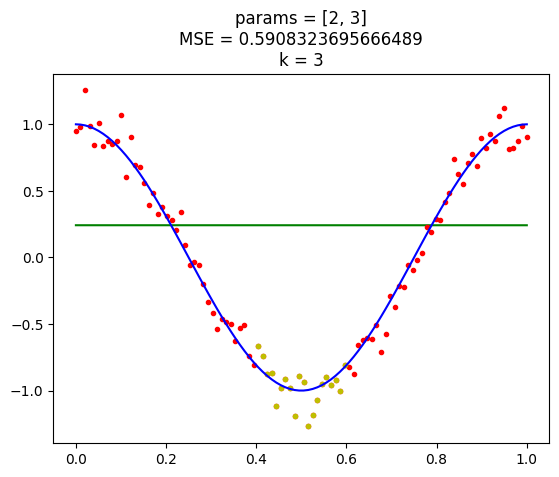

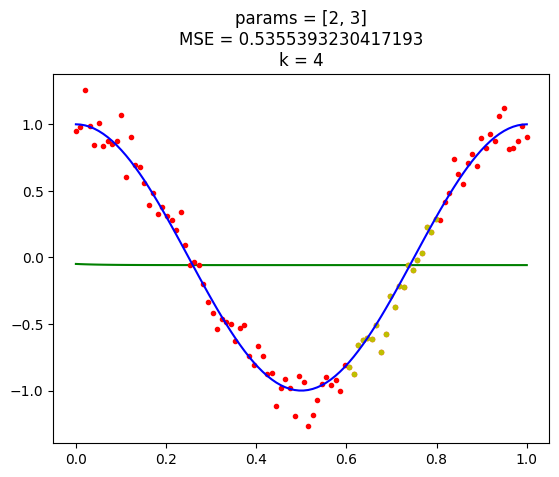

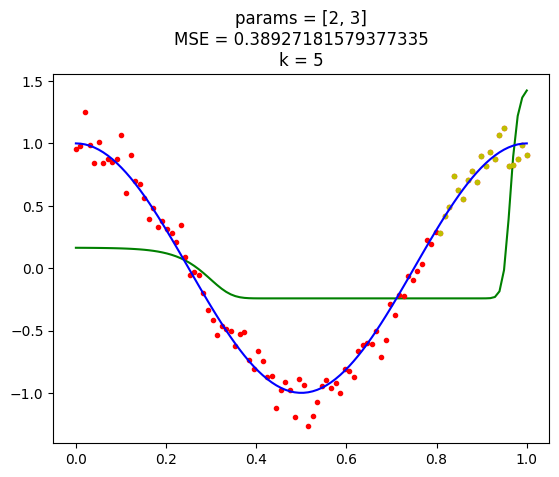

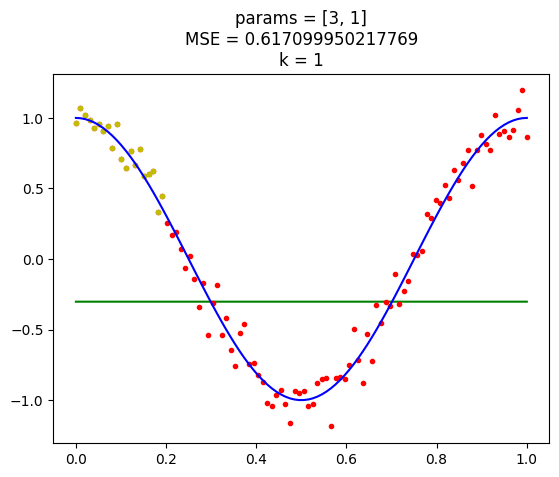

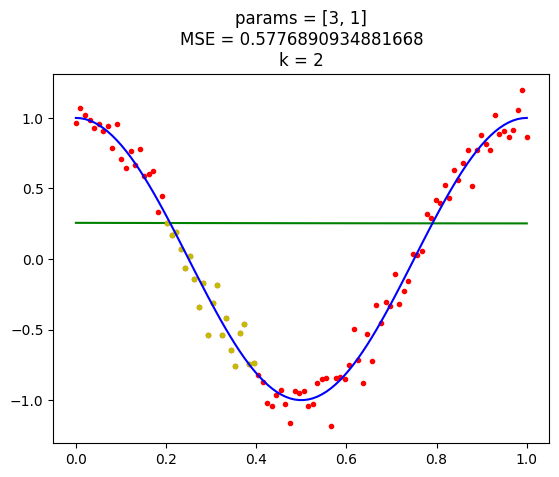

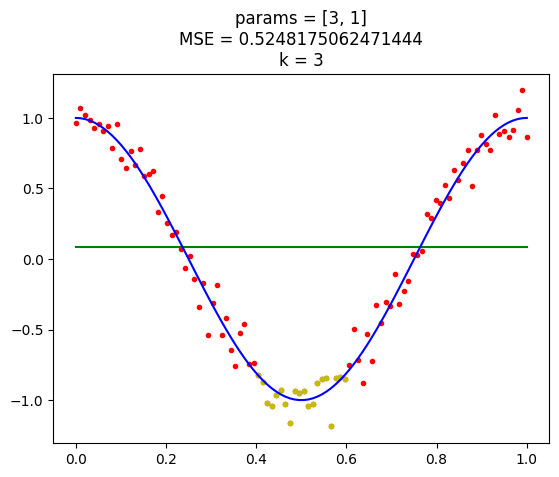

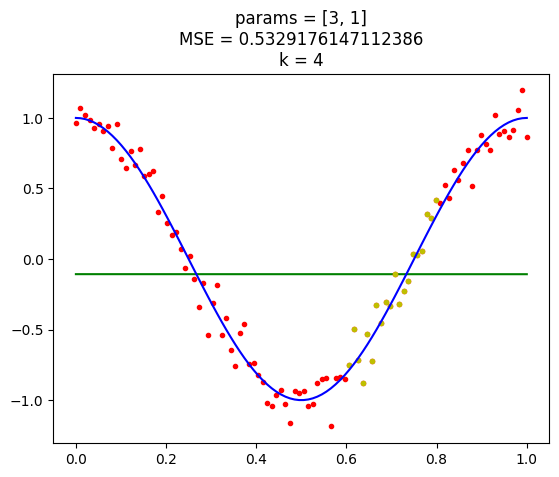

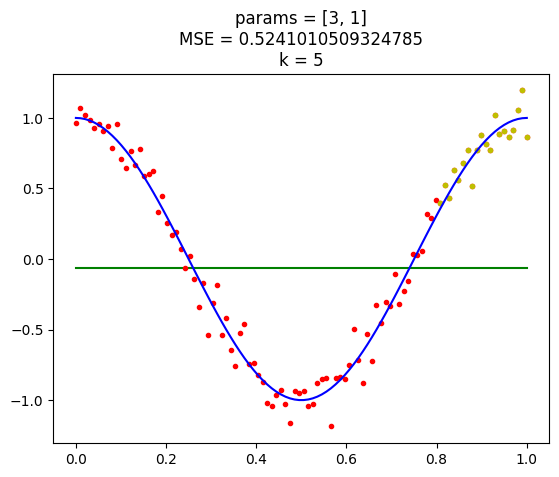

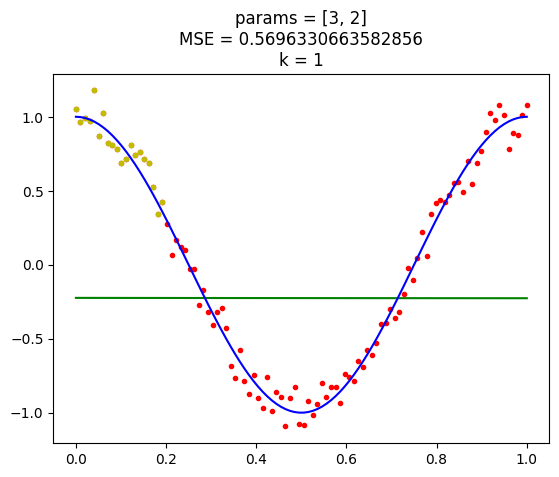

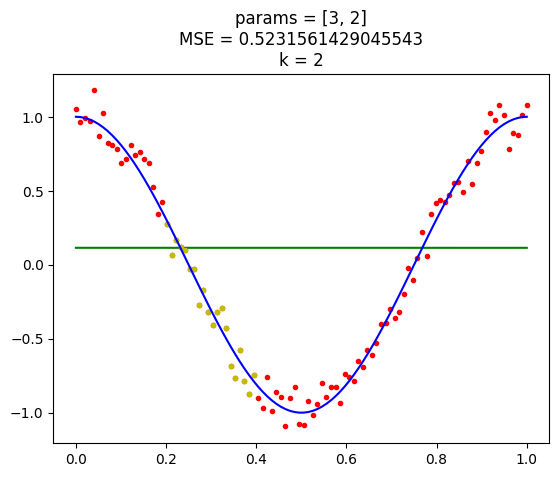

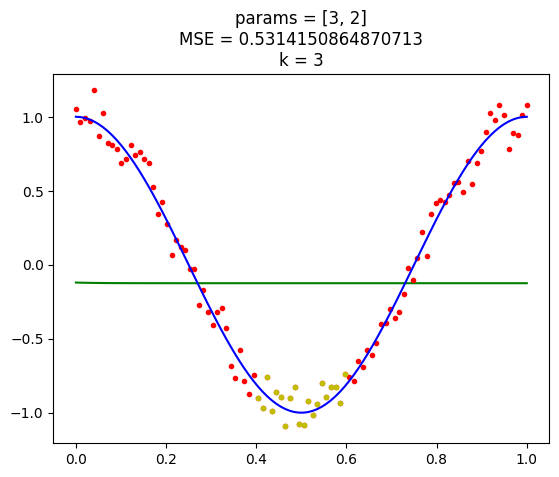

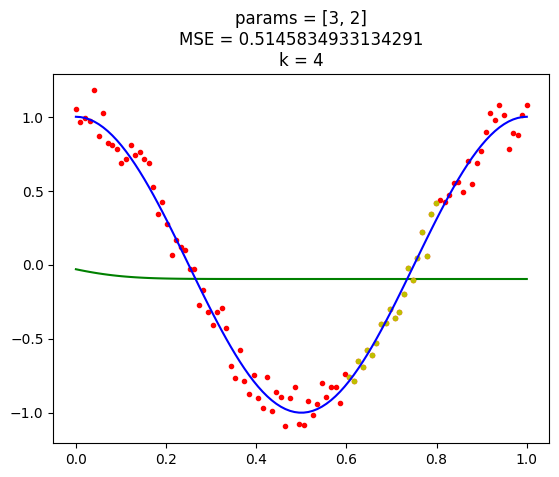

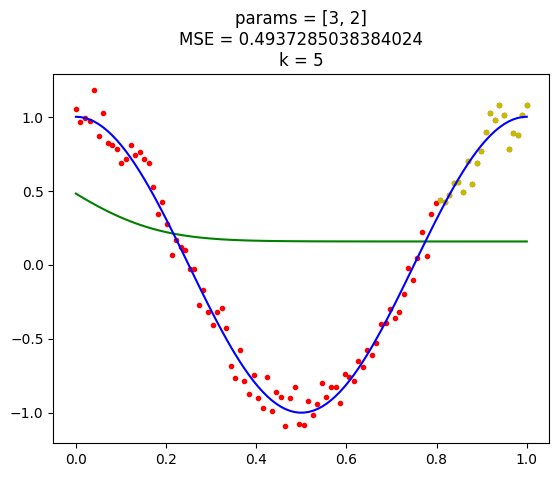

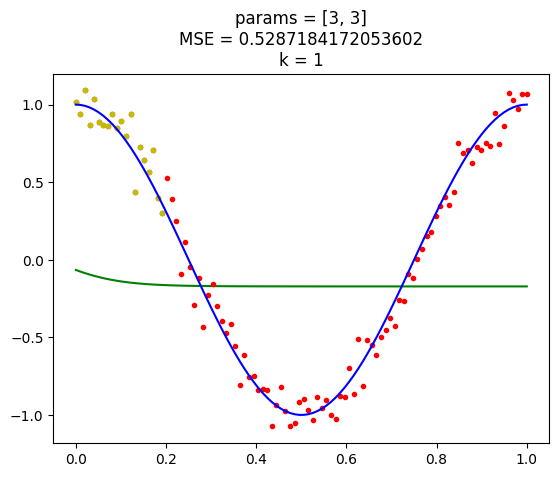

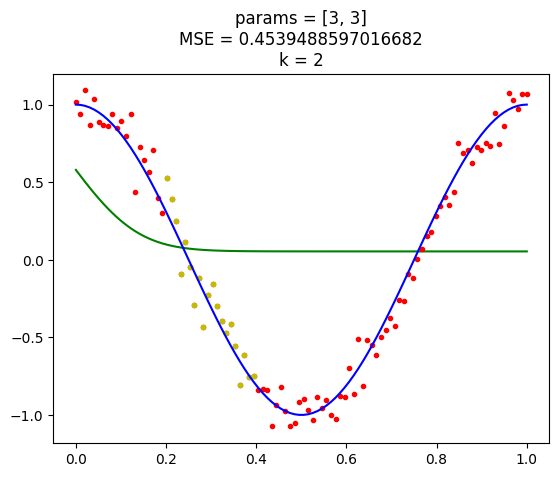

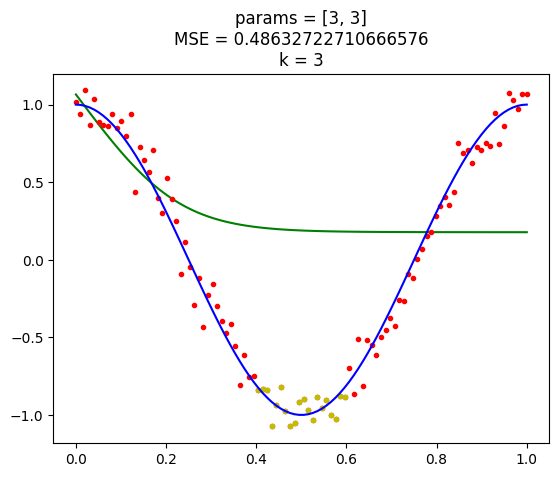

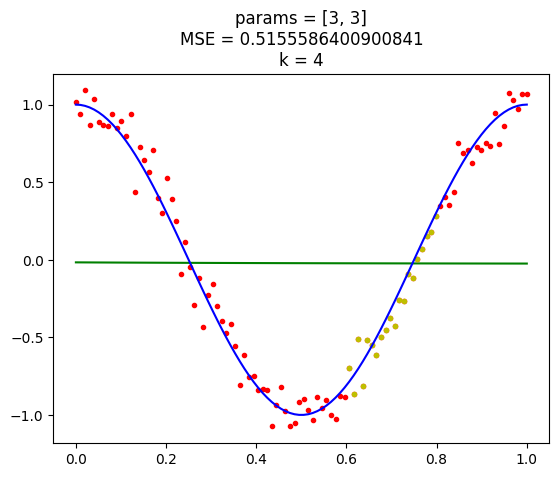

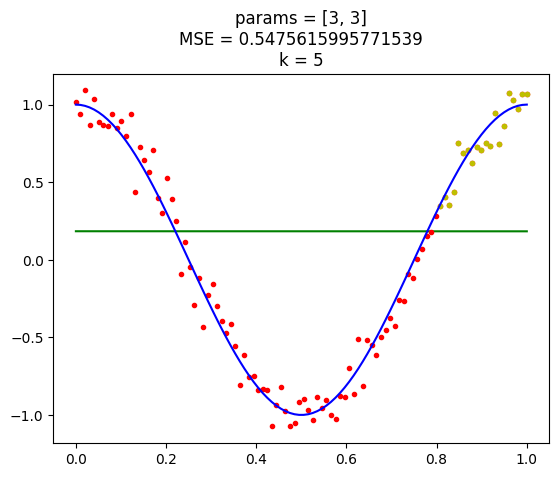

In [19]:
from sklearn.metrics import mean_squared_error

results = []

for param in params:
    k = 1
    avg_mean_squared_error = []
    y, y_noised = get_normal_noised_func_value('cos', x, 0, 0.1)
    y_noised_parts = np.array_split(y_noised, 5)
    
    for k in range(len(x_parts)):
        model = Perceptron(
            rate=0.1,
            layers_params=param,
            epoch_count=1000,
            batch_size=50
        )
        
        model.fit([[v] for v in x], [[v] for v in y_noised])
        res = model.predict([[v] for v in x])
        y_pred = [[v][0] for v in res]
        y_pred_parts = np.array_split(y_pred, 5)
        
        plt.title('params = ' + str(param) + '\n' + 'MSE = ' + str(mean_squared_error(y_noised, y_pred)) + '\n' + "k = " + str(k+1))
        
        avg_mean_squared_error.append(mean_squared_error(y_noised_parts[k], y_pred_parts[k]))
        
        plt.plot(x, y_pred, 'g-')
        plt.plot(x, y_noised, 'r.')
        plt.plot(x_parts[k], y_noised_parts[k], 'y.')
        plt.plot(x, y, 'b-')
        plt.show()
        
    results.append((param, np.average(avg_mean_squared_error)))

In [20]:
for t in (sorted(results, key=lambda t: t[1])):
    print('Layer Params = ', t[0], ' Error = ', t[1])

Layer Params =  [2, 2]  Error =  0.41644854954472743
Layer Params =  [1, 2]  Error =  0.48351574499068484
Layer Params =  [2]  Error =  0.49081487515865946
Layer Params =  [3, 2]  Error =  0.5160788636106698
Layer Params =  [1, 1]  Error =  0.5745488531519909
Layer Params =  [3, 3]  Error =  0.5918448185075063
Layer Params =  [1, 3]  Error =  0.6054774640413909
Layer Params =  [2, 1]  Error =  0.6514023217447379
Layer Params =  [3]  Error =  0.7189447432105032
Layer Params =  [3, 1]  Error =  0.7208974290805958
Layer Params =  [2, 3]  Error =  0.7332280930308247
Layer Params =  [1]  Error =  0.7802806116862888
